# Load Data

In [19]:
import pickle
import pandas as pd

# load the scenario properties file
with open('../scenario-properties-collision.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)
    

In [20]:
scenario_properties.full_coll

Matrix([
[                 -6.38342734488885e-13*pi*B_1*S_1 - 1.63371042652852e-9*pi*N_0.00141372kg_1*S_1 - 2.50961042191752e-14*pi*N_0.567kg_1*S_1 - 6.28108583824884e-14*pi*N_148kg_1*S_1 - 9.47247220948884e-14*pi*N_260kg_1*S_1 - 9.04476360707833e-14*pi*N_4kg_1*S_1 - 1.23109282429677e-13*pi*N_6kg_1*S_1 - 1.25621716764977e-18*pi*S_1**2 - 9.47247220948884e-19*pi*S_1*Su_1,                  -7.32935304873808e-13*pi*B_1*Su_1 - 3.42137355745772e-9*pi*N_0.00141372kg_1*Su_1 - 4.64705846640171e-14*pi*N_0.567kg_1*Su_1 - 9.47247220948884e-14*pi*N_148kg_1*Su_1 - 1.33171487096953e-13*pi*N_260kg_1*Su_1 - 1.28090982396697e-13*pi*N_4kg_1*Su_1 - 1.66482111369104e-13*pi*N_6kg_1*Su_1 - 9.47247220948884e-19*pi*S_1*Su_1 - 2.66342974193907e-18*pi*Su_1**2,                  -4.57191364213552e-8*pi*B_1*N_0.00141372kg_1 - 5.02486867059907e-12*pi*N_0.00141372kg_1**2 - 1.26830260491114e-10*pi*N_0.00141372kg_1*N_0.567kg_1 - 1.63371042652852e-9*pi*N_0.00141372kg_1*N_148kg_1 - 3.42137355745772e-9*pi*N_0.00141372kg_1

# Initial Population

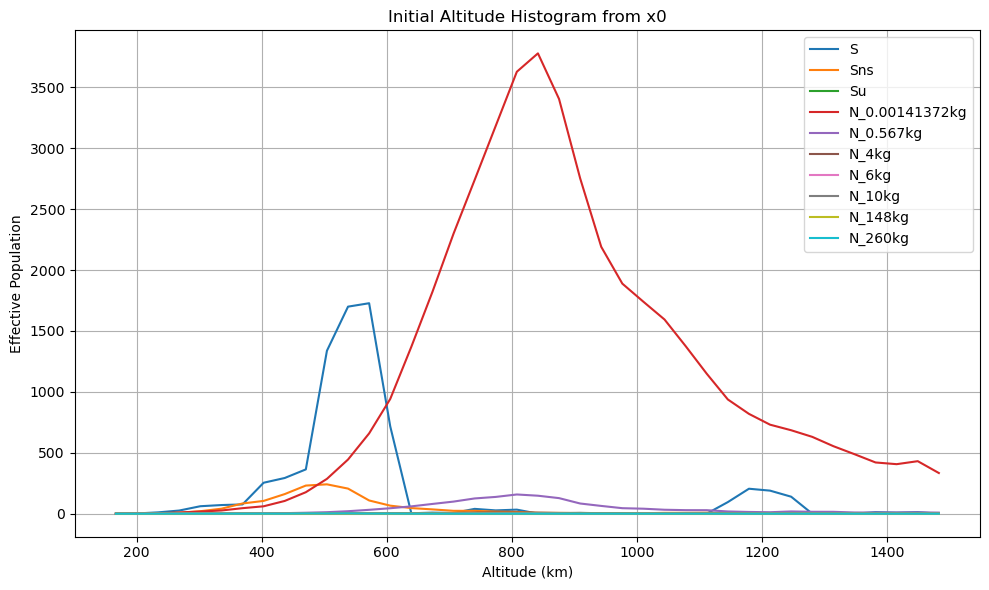

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack inputs
x0 = scenario_properties.x0  # shape: (sma, species, ecc)
TIS = scenario_properties.time_in_shell  # shape: (altitude, ecc, sma)
altitudes = scenario_properties.HMid  # length: n_alt_shells
species_names = scenario_properties.species_names

n_sma_bins, n_species, n_ecc_bins = x0.shape
n_alt_shells = TIS.shape[0]

# --- Calculate effective population in each altitude shell per species ---
effective_altitude_matrix = np.zeros((n_alt_shells, n_species))

for species in range(n_species):
    for alt_shell in range(n_alt_shells):
        total = 0.0
        for sma in range(n_sma_bins):
            for ecc in range(n_ecc_bins):
                n_pop = x0[sma, species, ecc]
                tis = TIS[alt_shell, ecc, sma]
                total += n_pop * tis
        effective_altitude_matrix[alt_shell, species] = total

# --- Plot: One line per species ---
plt.figure(figsize=(10, 6))
for s in range(n_species):
    plt.plot(altitudes, effective_altitude_matrix[:, s], label=species_names[s])

plt.xlabel("Altitude (km)")
plt.ylabel("Effective Population")
plt.title("Initial Altitude Histogram from x0")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # Log scale for better visibility
plt.show()

In [18]:
import numpy as np

sp = scenario_properties
# dims
n_sma    = sp.n_shells
n_species= sp.species_length
n_ecc    = len(sp.eccentricity_bins) - 1
# assume output.y is flat: (sma * species * ecc, time)
y_flat   = sp.output.y
n_time   = y_flat.shape[1]

# reshape to (sma, species, ecc, time)
x4d = y_flat.reshape(n_sma, n_species, n_ecc, n_time)

# prepare output
n_alt    = len(sp.HMid)
alt_mat  = np.zeros((n_alt, n_species, n_time))

# for each time‐slice, project into altitude
for t in range(n_time):
    # build a full (sma, species, ecc) block at time t
    pop_block = x4d[:, :, :, t]  # shape (sma, species, ecc)
    # convert to altitude‐species matrix: (n_alt, n_species)
    alt_proj = sp.sma_ecc_mat_to_altitude_mat(pop_block)
    # store
    alt_mat[:, :, t] = alt_proj

# times and altitude axes
times     = np.array(sp.output.t)
altitudes = np.array(sp.HMid)

In [27]:
# %%  
# Single cell: project SMA×ecc into altitude, then export pop_time.csv & pop_time_alt.csv

import os
import numpy as np
import pandas as pd

# — adjust these as needed — 
output_dir = "output_alt"
os.makedirs(output_dir, exist_ok=True)

# shortcut
sp = scenario_properties

# dims
n_sma    = sp.n_shells
n_sp     = sp.species_length
n_ecc    = len(sp.eccentricity_bins) - 1
n_time   = sp.output.y.shape[1]
times    = np.array(sp.output.t)
alts     = np.array(sp.HMid)
names    = sp.species_names

# reshape into (sma, species, ecc, time)
y4d = sp.output.y.reshape(n_sma, n_sp, n_ecc, n_time)

# build altitude‐projected 3D array [alt, species, time]
y_alt = np.zeros((n_sma, n_sp, n_time))
for t in range(n_time):
    # take SMA×ecc slice for each species
    block = y4d[:, :, :, t]              # (sma, species, ecc)
    # project into altitudes via your converter
    proj  = sp.sma_ecc_mat_to_altitude_mat(block)  # returns (alt, species)
    y_alt[:, :, t] = proj

# 1) pop_time.csv  — total pop per species per year
rows = []
for i, code in enumerate(names):
    for t, offset in enumerate(times):
        year = int(sp.start_year + offset)
        pop  = float(y_alt[:, i, t].sum())
        rows.append({"Species": code, "Year": year, "Population": pop})
df_time = pd.DataFrame(rows).groupby(["Species","Year"], as_index=False).sum()
df_time.to_csv(f"{output_dir}/pop_time.csv", index=False)

# 2) pop_time_alt.csv — pop per species×altitude×year
rows = []
for i, code in enumerate(names):
    for a_idx, alt in enumerate(alts):
        for t, offset in enumerate(times):
            year = int(sp.start_year + offset)
            pop  = float(y_alt[a_idx, i, t])
            rows.append({
                "Species":    code,
                "Year":       year,
                "Altitude":   alt,
                "Population": pop
            })
df_alt = pd.DataFrame(rows).groupby(
    ["Species","Year","Altitude"], as_index=False
).sum()
df_alt.to_csv(f"{output_dir}/pop_time_alt.csv", index=False)

print("Wrote:", 
      f"{output_dir}/pop_time.csv  ({len(df_time)} rows),",
      f"{output_dir}/pop_time_alt.csv  ({len(df_alt)} rows)")

AttributeError: 'ScenarioProperties' object has no attribute 'start_year'

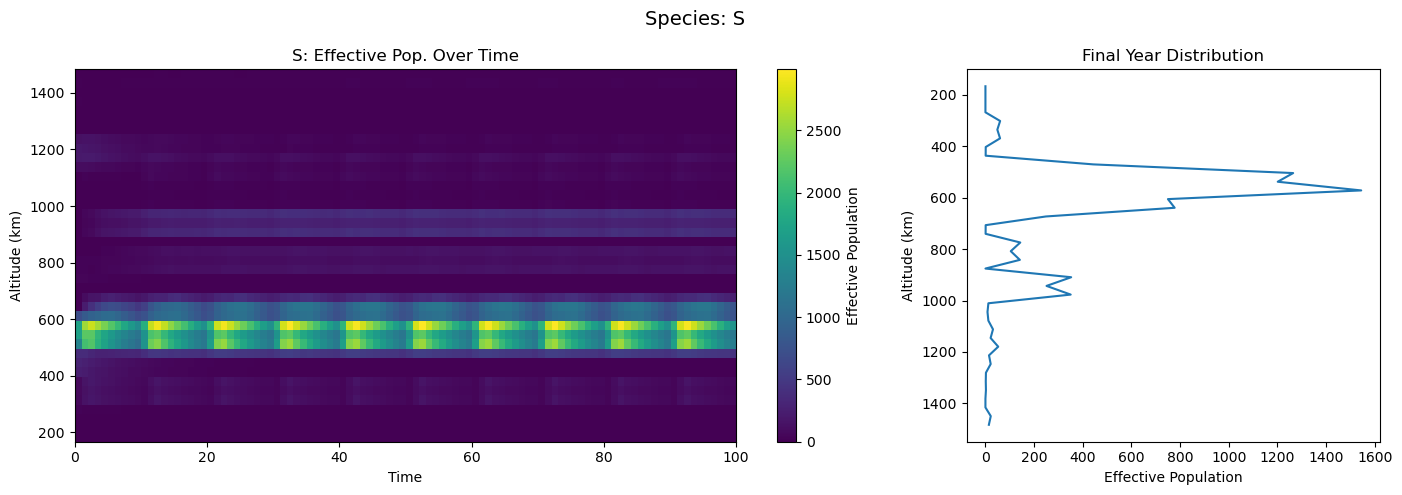

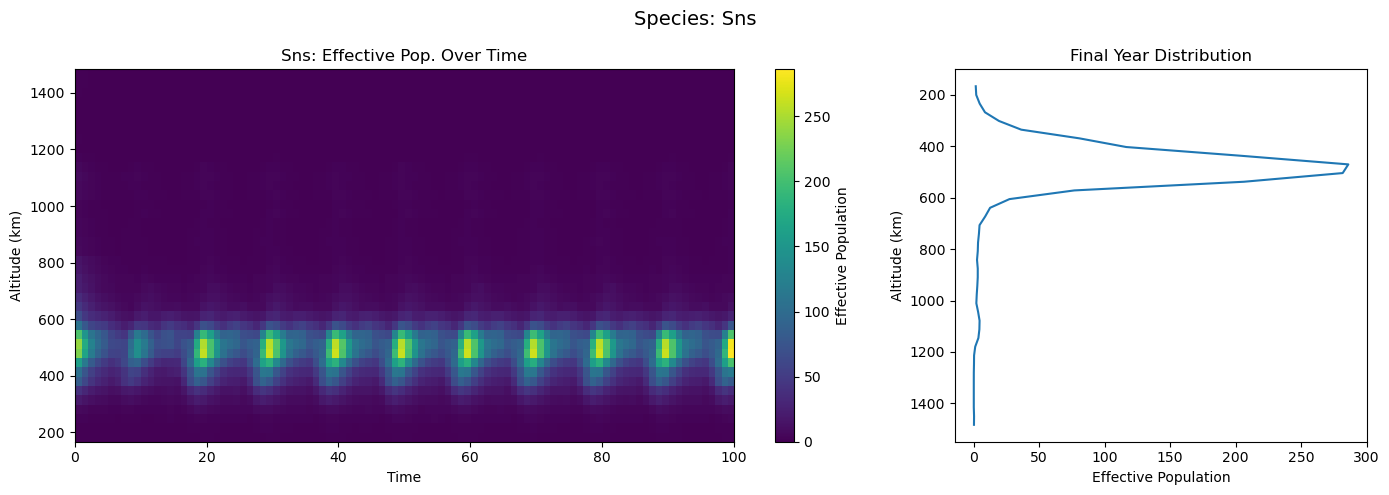

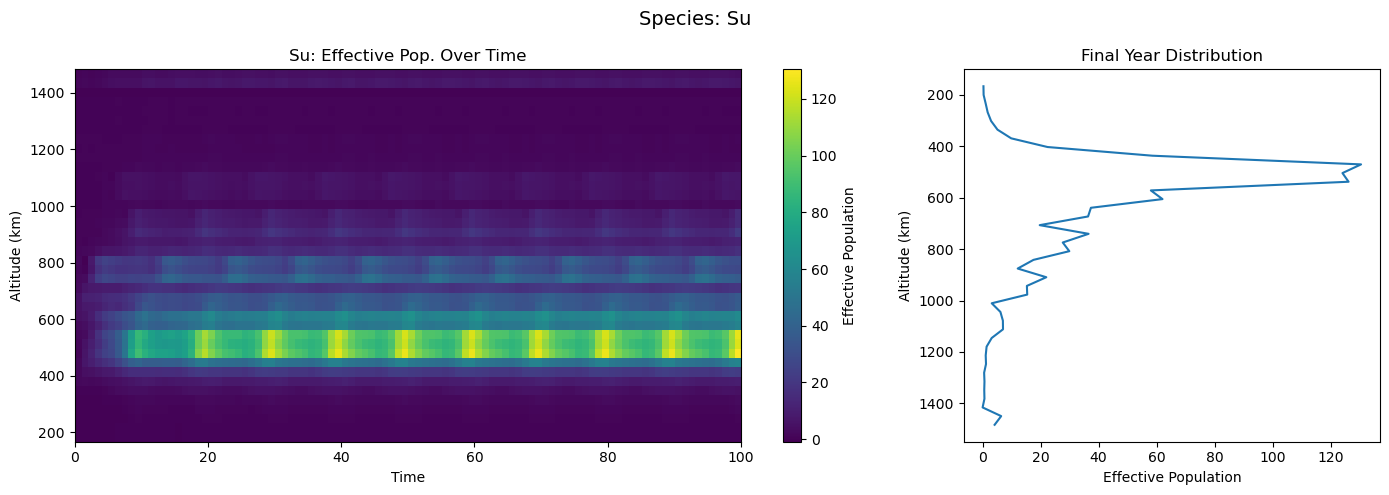

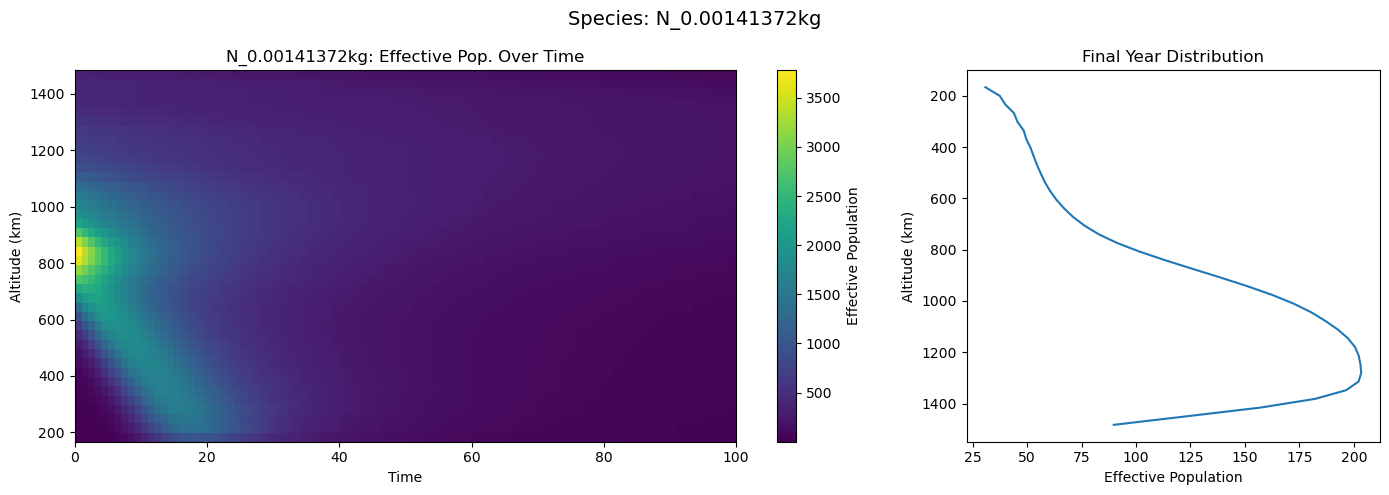

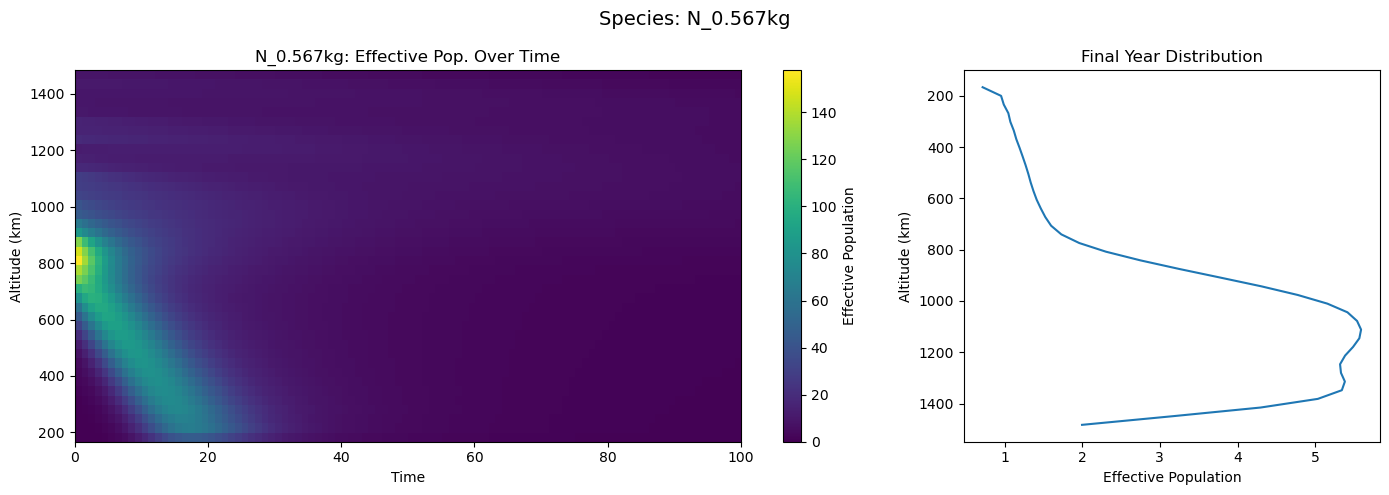

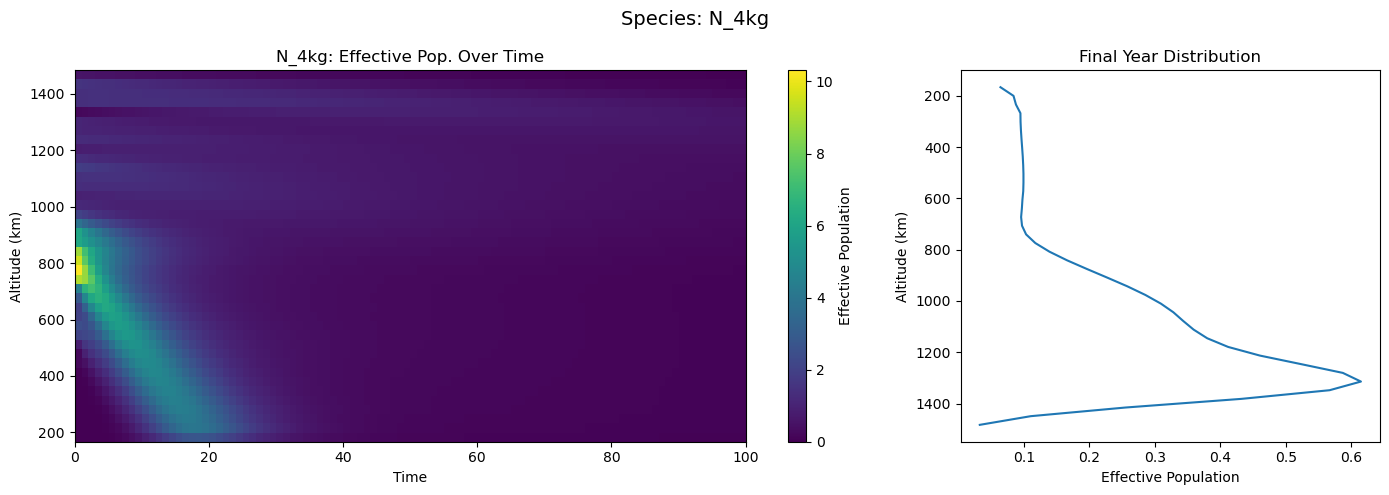

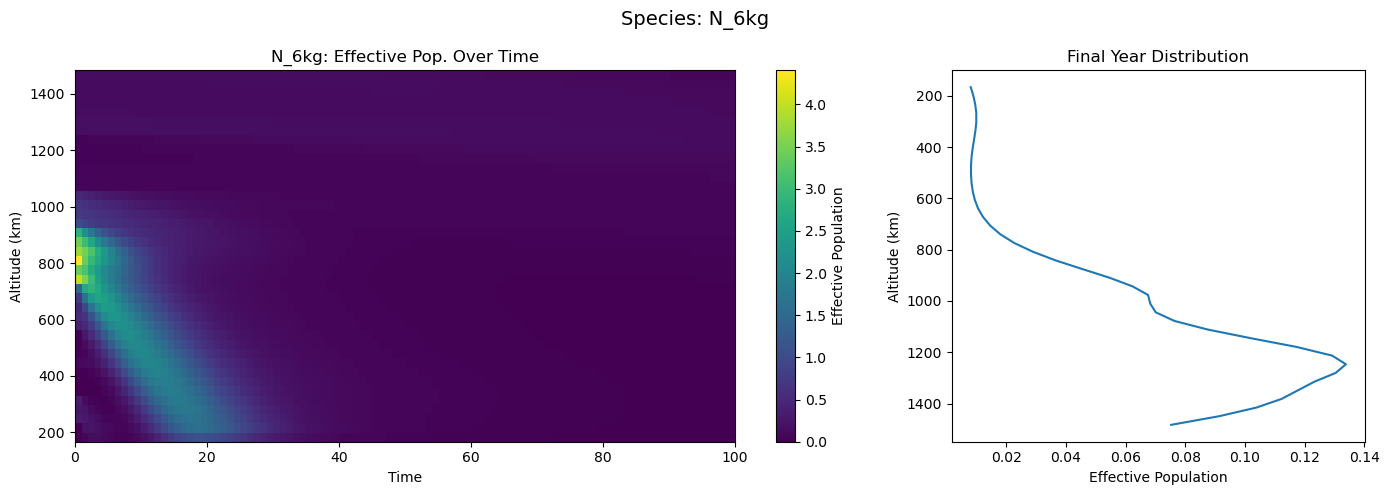

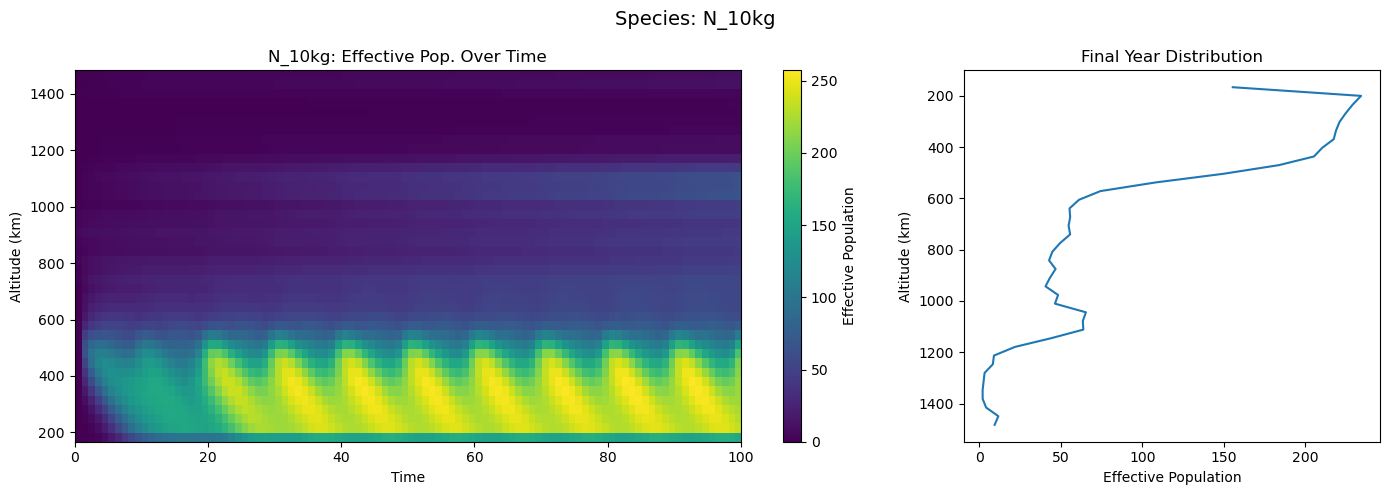

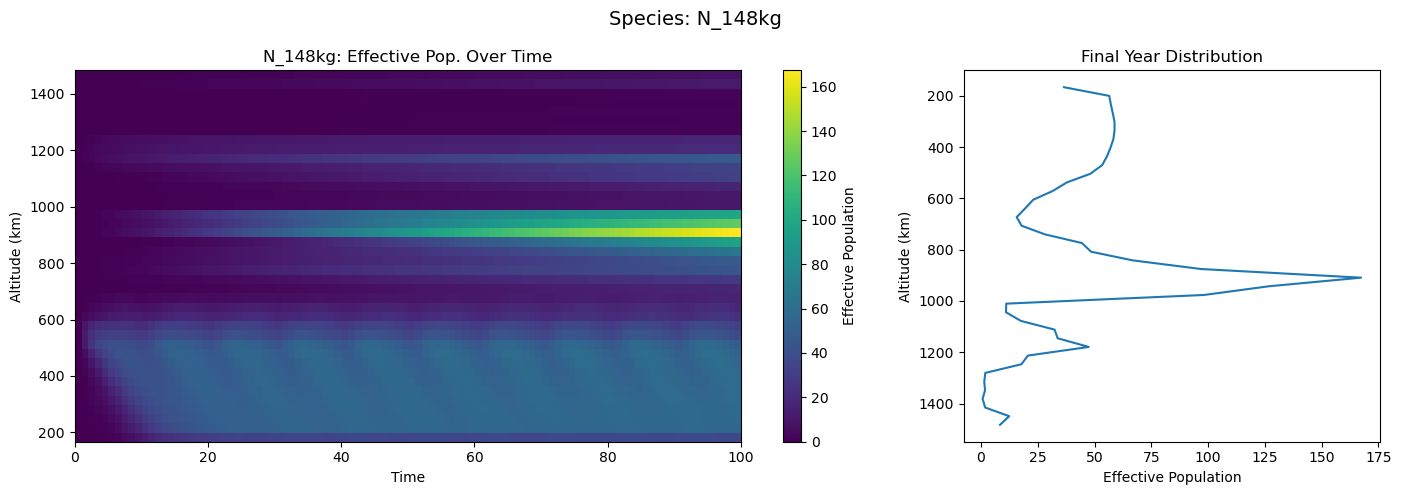

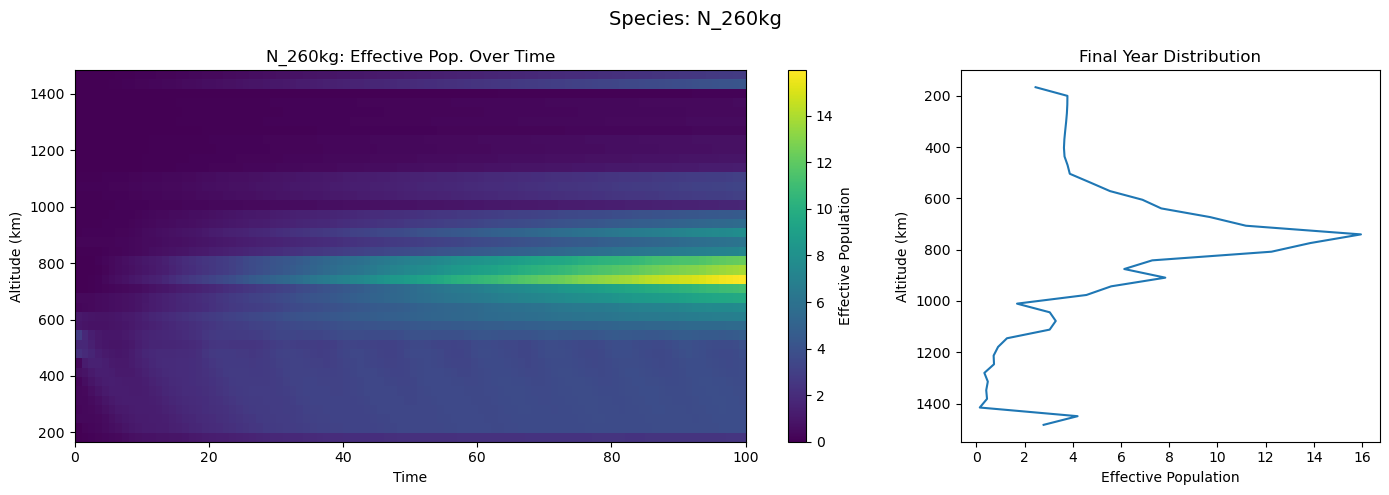

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_alt_shells = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
n_time = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # Altitude midpoints

# --- Unpack population data ---
y = scenario_properties.output.y
x_matrix = y.reshape(n_sma_bins, n_species, n_ecc_bins, n_time)  # shape: (sma, species, ecc, time)

# === Plotting ===
for s in range(n_species):
    n_eff_time = np.zeros((n_alt_shells, n_time))  # Altitude shells × time

    for t in range(n_time):
        pop_snapshot = x_matrix[:, s, :, t]  # shape: (sma, ecc)
        
        # Reconstruct full shape (sma, species, ecc) to use in converter
        pop_full = np.zeros((n_sma_bins, n_species, n_ecc_bins))
        pop_full[:, s, :] = pop_snapshot

        # Convert to altitude matrix using your method
        alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(pop_full)
        n_eff_time[:, t] = alt_proj[:, s]

    # Final year distribution
    final_year_dist = n_eff_time[:, -1]

    # --- Create subplot: Heatmap + Final Distribution ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Heatmap of effective population over time
    im = axes[0].imshow(n_eff_time, aspect='auto', origin='lower',
                        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
                        cmap='viridis')
    axes[0].set_title(f"{species_names[s]}: Effective Pop. Over Time")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Altitude (km)")
    plt.colorbar(im, ax=axes[0], label="Effective Population")

    # Right: Final year distribution
    axes[1].plot(final_year_dist, altitudes)
    axes[1].set_title("Final Year Distribution")
    axes[1].set_xlabel("Effective Population")

    axes[1].set_ylabel("Altitude (km)")
    axes[1].invert_yaxis()

    plt.suptitle(f"Species: {species_names[s]}", fontsize=14)
    plt.tight_layout()
    plt.show()

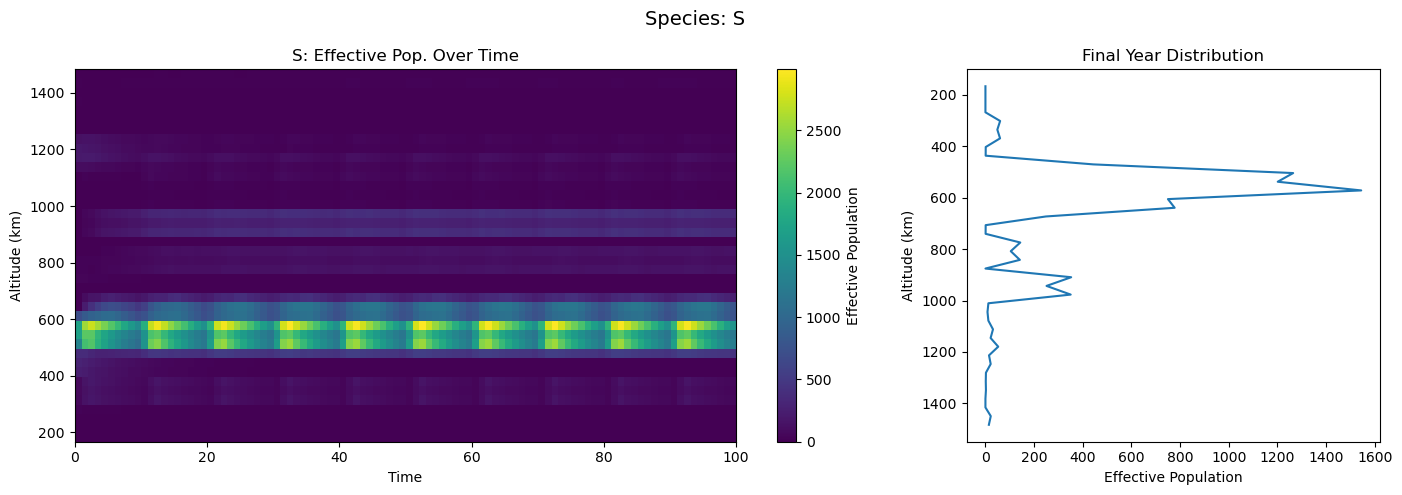

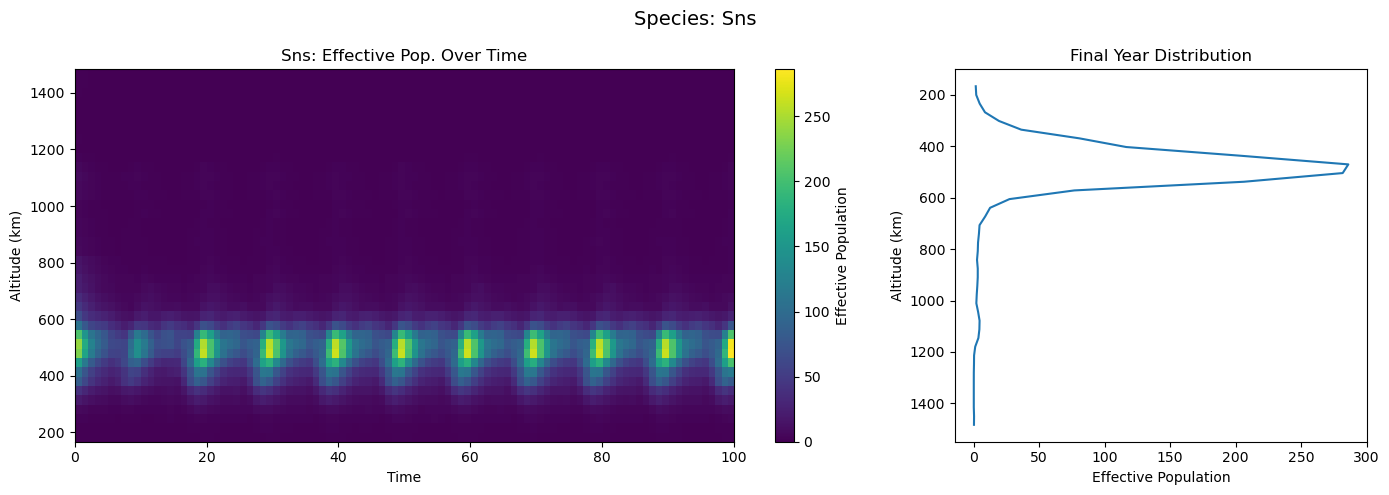

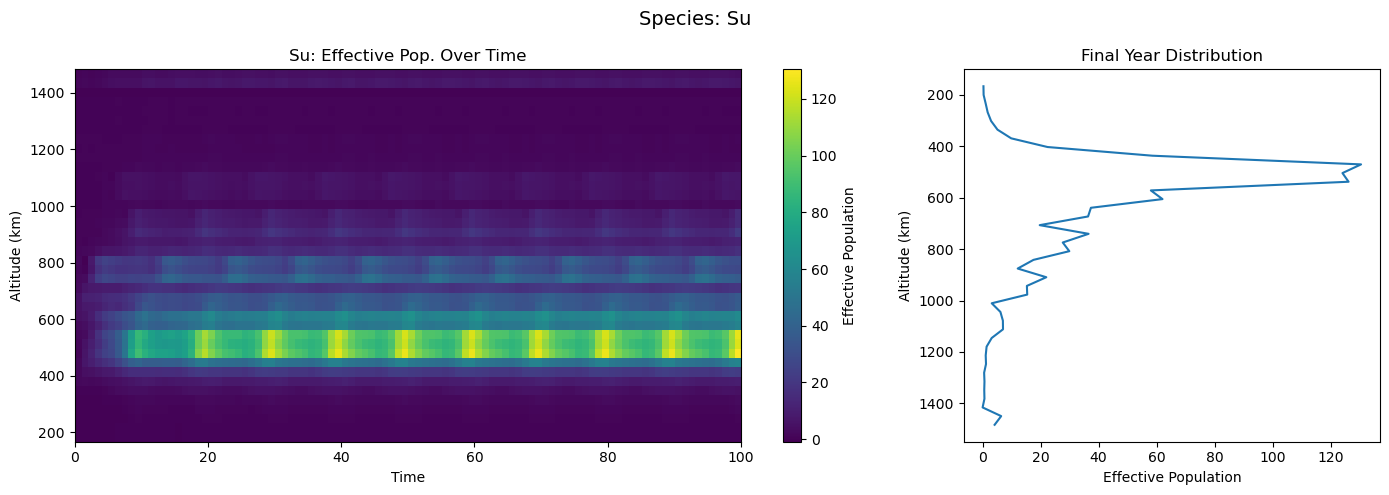

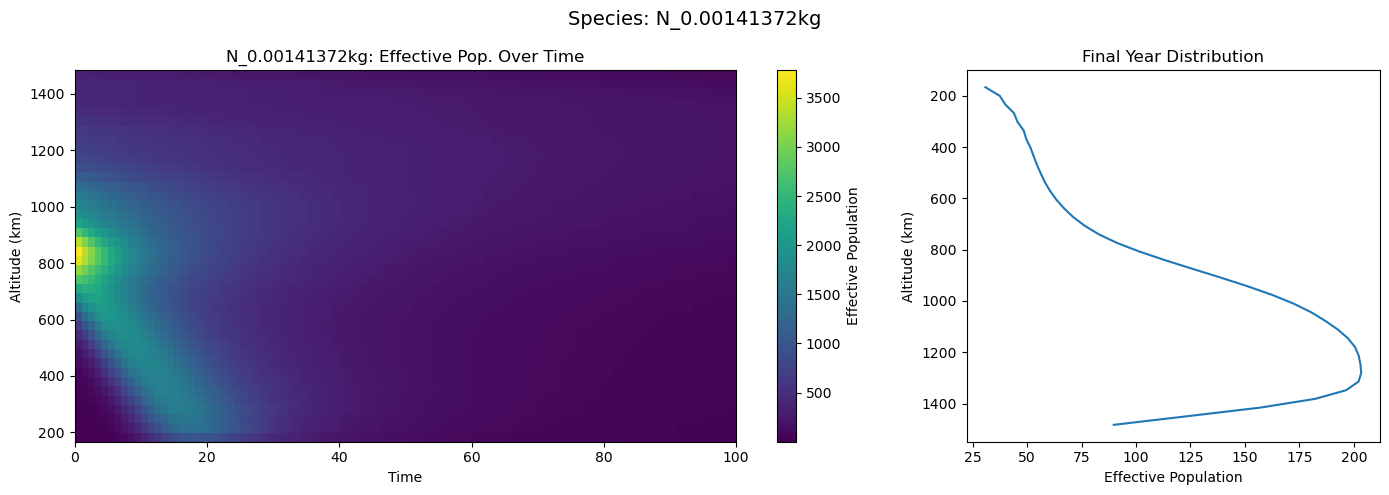

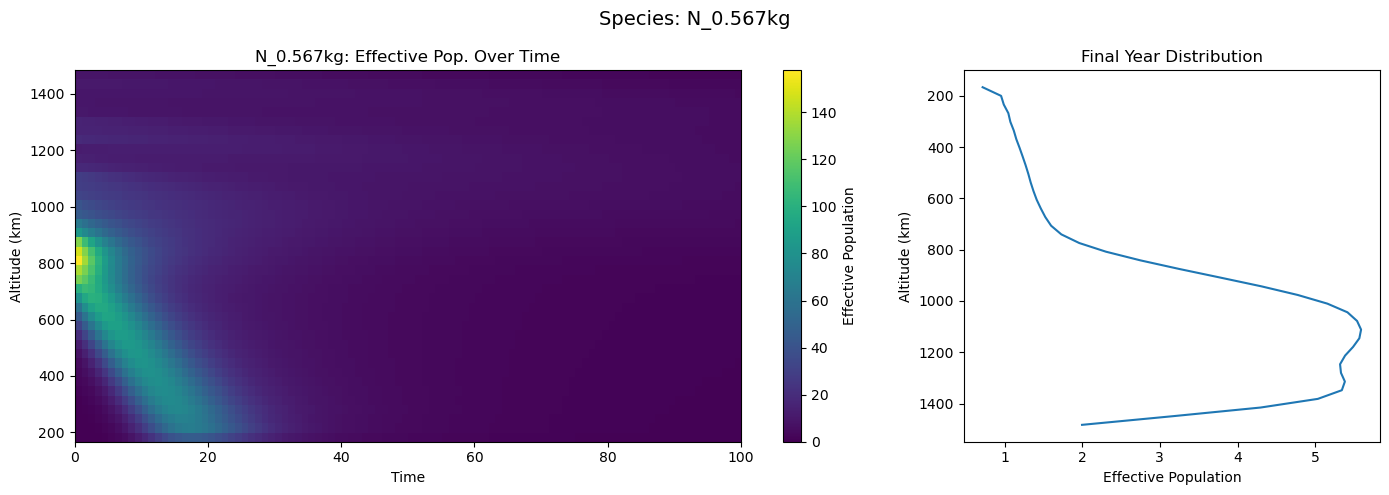

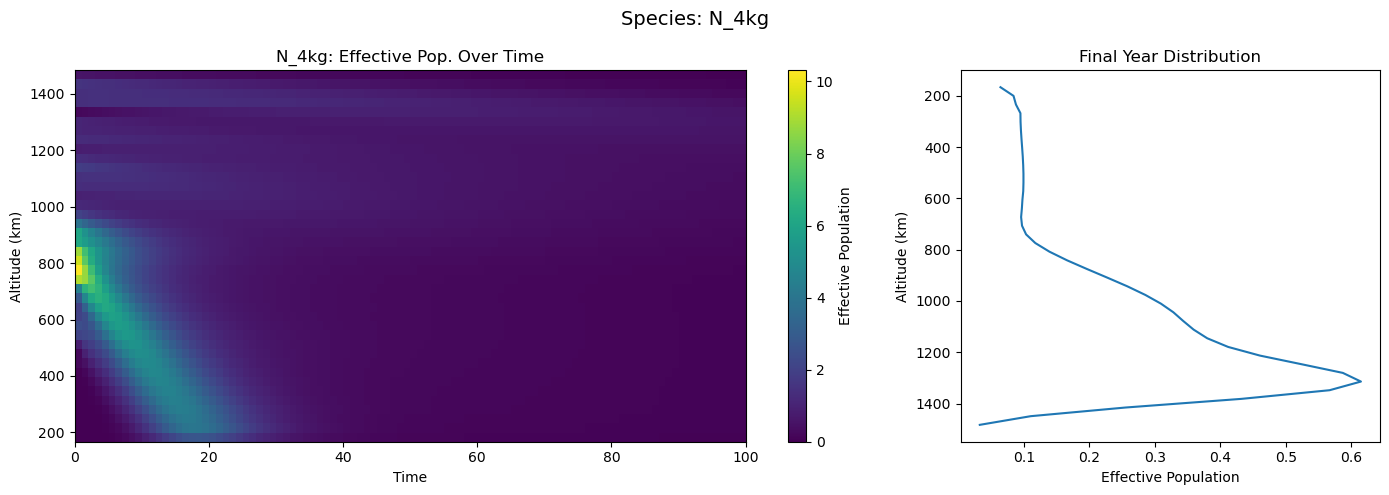

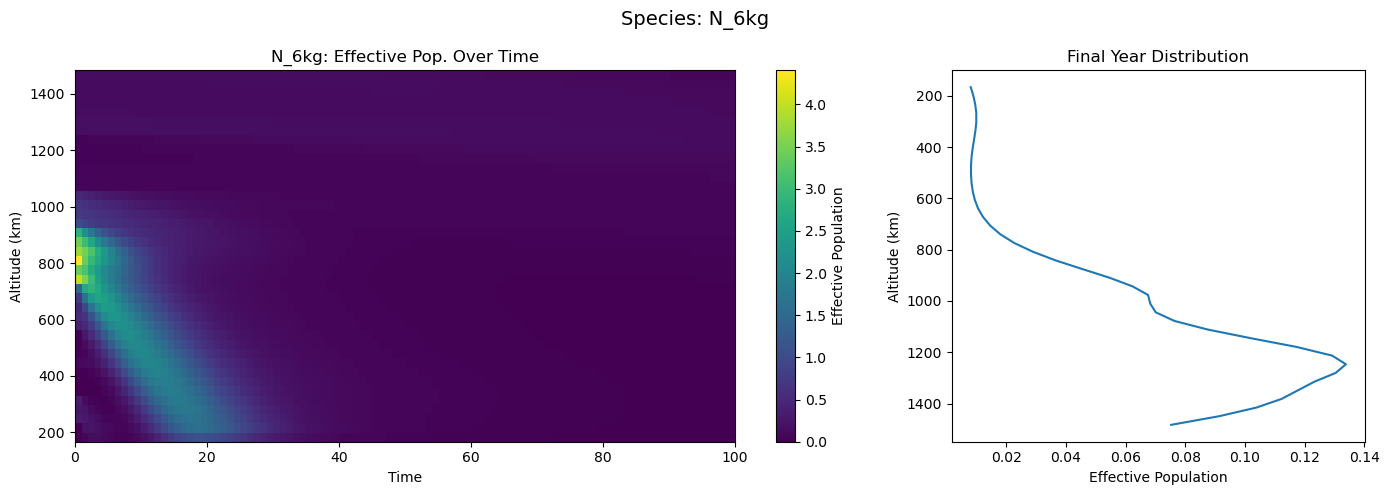

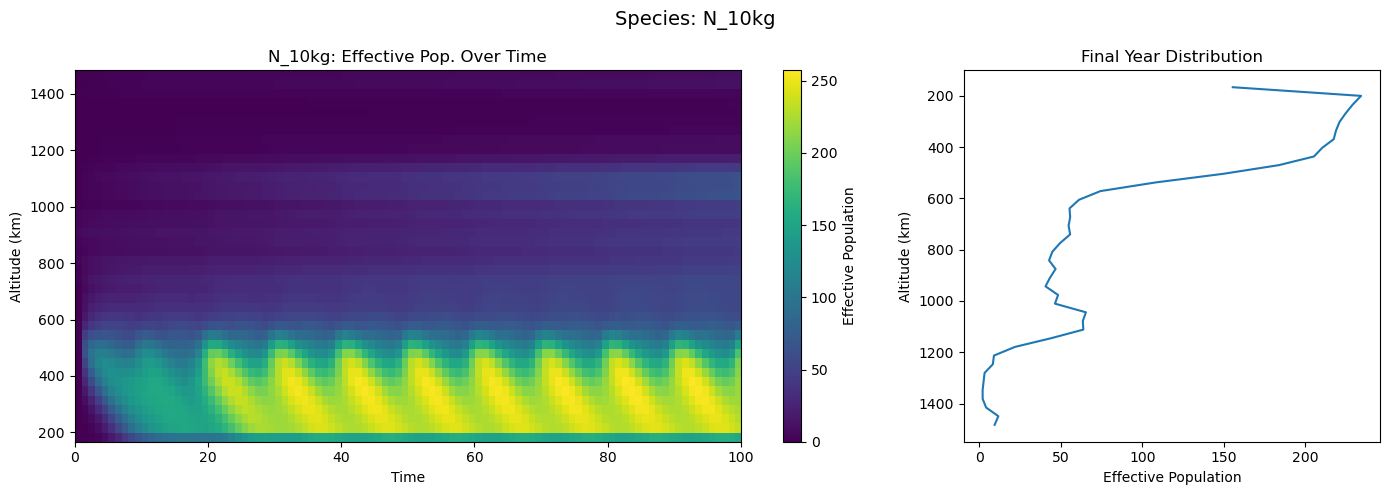

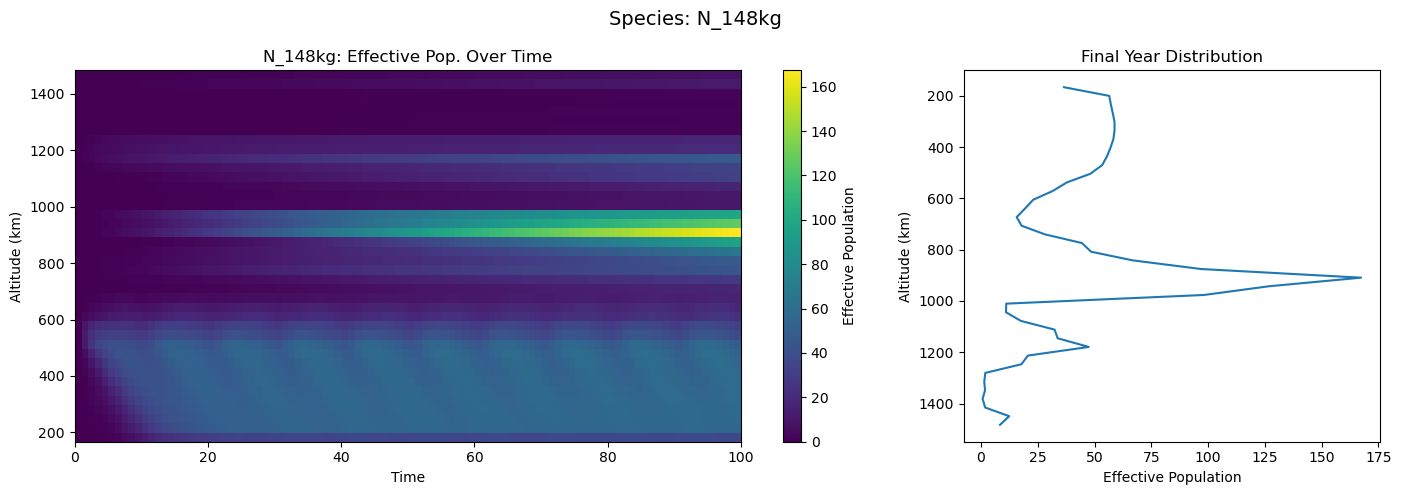

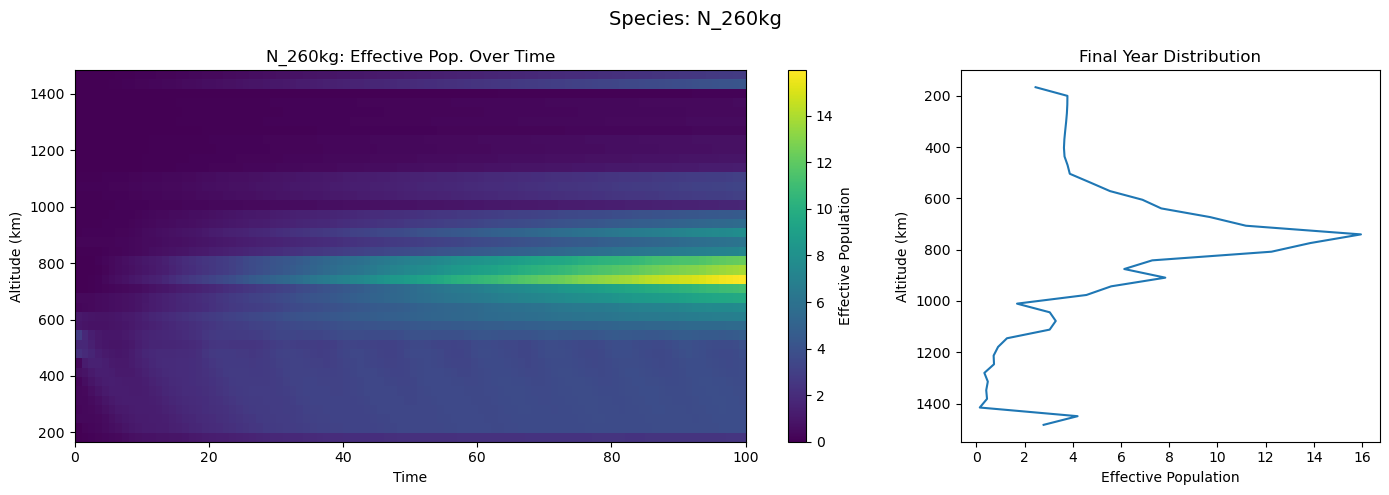

Saved total population over time to output_alt/pop_time.csv
Saved altitude-resolved population data to output_alt/pop_time_alt.csv


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- Scenario properties ---
start_year = 2025
simulation_name = 'test'
base_path = output_dir or f"figures/{simulation_name}"

# --- Dimensions ---
n_sma_bins    = scenario_properties.n_shells
n_alt_shells  = scenario_properties.n_shells
n_species     = scenario_properties.species_length
n_ecc_bins    = len(scenario_properties.eccentricity_bins) - 1
n_time        = scenario_properties.output.y.shape[1]
times         = scenario_properties.output.t
species_names = scenario_properties.species_names
altitudes     = scenario_properties.HMid  # Altitude midpoints

# --- Unpack population data ---
y = scenario_properties.output.y
x_matrix = y.reshape(n_sma_bins, n_species, n_ecc_bins, n_time)

# --- Prepare containers for CSV export ---
pop_time_rows     = []  # total pop per species & year
pop_time_alt_rows = []  # pop per species, year & altitude

# === Compute, plot, and collect data ===
for s in range(n_species):
    # Effective population over time (by altitude)
    n_eff_time = np.zeros((n_alt_shells, n_time))

    for t_idx, offset in enumerate(times):
        # Extract snapshot and project to altitude
        pop_snapshot = x_matrix[:, s, :, t_idx]               # (sma, ecc)
        pop_full     = np.zeros((n_sma_bins, n_species, n_ecc_bins))
        pop_full[:, s, :] = pop_snapshot

        alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(pop_full)
        n_eff_time[:, t_idx] = alt_proj[:, s]

        # Collect altitude-resolved rows
        year = int(start_year + offset)
        for alt_idx, alt in enumerate(altitudes):
            pop_time_alt_rows.append({
                "Species":    species_names[s],
                "Year":       year,
                "Altitude":   alt,
                "Population": alt_proj[alt_idx, s]
            })

    # Collect total-population rows
    for t_idx, offset in enumerate(times):
        year      = int(start_year + offset)
        total_pop = n_eff_time[:, t_idx].sum()
        pop_time_rows.append({
            "Species":    species_names[s],
            "Year":       year,
            "Population": total_pop
        })

    # --- Plotting: Heatmap + Final Distribution ---
    final_year_dist = n_eff_time[:, -1]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Heatmap
    im = axes[0].imshow(
        n_eff_time,
        aspect='auto',
        origin='lower',
        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
        cmap='viridis'
    )
    axes[0].set_title(f"{species_names[s]}: Effective Pop. Over Time")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Altitude (km)")
    plt.colorbar(im, ax=axes[0], label="Effective Population")

    # Right: Final year distribution
    axes[1].plot(final_year_dist, altitudes)
    axes[1].set_title("Final Year Distribution")
    axes[1].set_xlabel("Effective Population")
    axes[1].set_ylabel("Altitude (km)")
    axes[1].invert_yaxis()

    plt.suptitle(f"Species: {species_names[s]}", fontsize=14)
    plt.tight_layout()
    plt.show()

# === Export to CSV ===
# Total population per species over time
df_pop_time = pd.DataFrame(pop_time_rows)
df_pop_time = (
    df_pop_time
    .groupby(["Species", "Year"], as_index=False)
    .sum()
    .sort_values(["Species", "Year"])
    .reset_index(drop=True)
)
pop_time_path = os.path.join(base_path, "pop_time.csv")
df_pop_time.to_csv(pop_time_path, index=False)
print(f"Saved total population over time to {pop_time_path}")

# Altitude-resolved population per species over time
df_pop_time_alt = pd.DataFrame(pop_time_alt_rows)
df_pop_time_alt = (
    df_pop_time_alt
    .groupby(["Species", "Year", "Altitude"], as_index=False)
    .sum()
    .sort_values(["Species", "Year", "Altitude"])
    .reset_index(drop=True)
)
pop_time_alt_path = os.path.join(base_path, "pop_time_alt.csv")
df_pop_time_alt.to_csv(pop_time_alt_path, index=False)
print(f"Saved altitude-resolved population data to {pop_time_alt_path}")

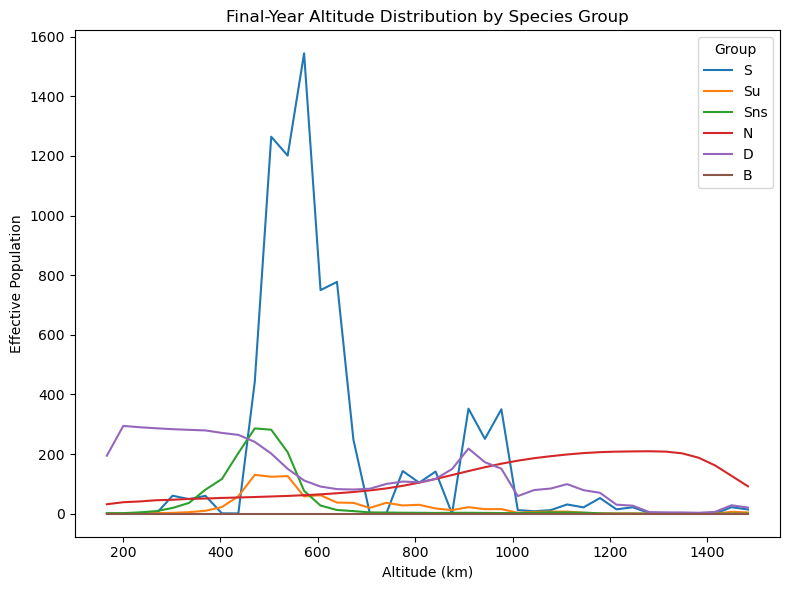

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions & data ---
n_sma_bins    = scenario_properties.n_shells
n_ecc_bins    = len(scenario_properties.eccentricity_bins) - 1
n_species     = scenario_properties.species_length
n_time        = scenario_properties.output.y.shape[1]
altitudes     = scenario_properties.HMid            # Altitude midpoints (km)
species_names = scenario_properties.species_names

# Final snapshot
y_final       = scenario_properties.output.y[:, -1]
x_final       = y_final.reshape((n_sma_bins, n_species, n_ecc_bins))
alt_proj_full = scenario_properties.sma_ecc_mat_to_altitude_mat(x_final)
# shape: (n_alt_shells, n_species)

# --- Group definitions ---
large_fragments = {'N_10kg', 'N_148kg', 'N_260kg', 'N_472kg', 'N_750kg', 'N_1250kg'}
group_indices = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N':   [i for i, sp in enumerate(species_names) 
            if sp.startswith('N') and sp not in large_fragments],
    'D':   [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp == 'B']
}

# --- Sum per group ---
group_alt_dists = {
    grp: alt_proj_full[:, idxs].sum(axis=1)
    for grp, idxs in group_indices.items()
}

# --- Plot with axes swapped ---
plt.figure(figsize=(8, 6))
for grp, dist in group_alt_dists.items():
    plt.plot(altitudes, dist, label=grp)

plt.ylabel("Effective Population")
plt.xlabel("Altitude (km)")
plt.title("Final‐Year Altitude Distribution by Species Group")
plt.legend(title="Group")
plt.tight_layout()
plt.show()

# Effective Altitude

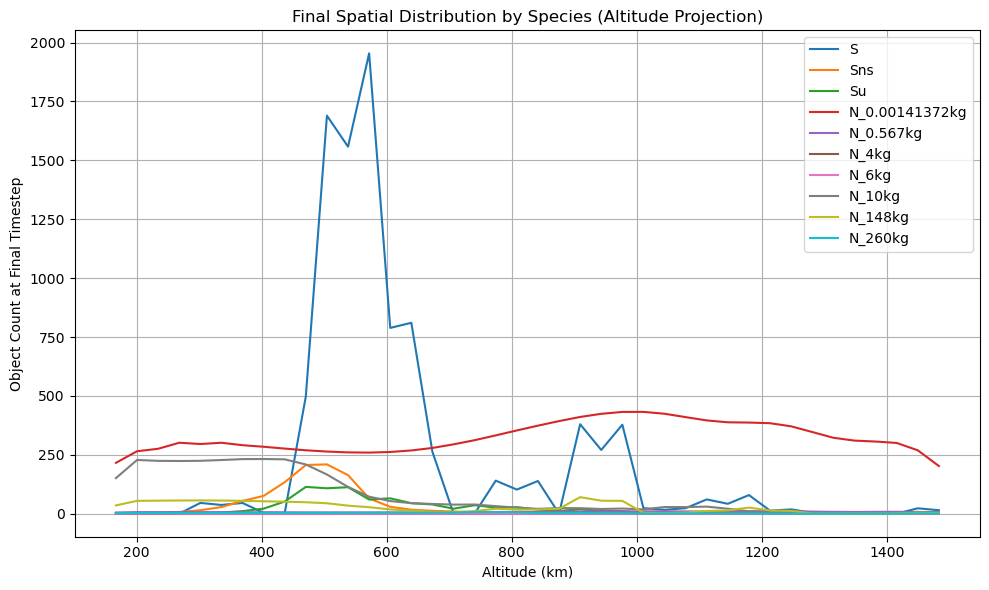

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack dimensions
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # shape: (n_shells,)
final_step_index = 40 # last times÷tep

# Extract final timestep and reshape
y = scenario_properties.output.y
y_final = y[:, final_step_index]  # shape: (n_sma_bins * n_species * n_ecc_bins,)

# Reshape to (sma, species, ecc)
x_matrix = y_final.reshape((n_sma_bins, n_species, n_ecc_bins))

# Project to altitude using provided method
x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)  # shape: (n_shells, n_species)

# === Plot: Total Altitude Distribution per Species ===
plt.figure(figsize=(10, 6))

for i in range(n_species):
    plt.plot(altitudes, x_alt[:, i], label=species_names[i])

plt.xlabel("Altitude (km)")
plt.ylabel("Object Count at Final Timestep")
plt.title("Final Spatial Distribution by Species (Altitude Projection)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

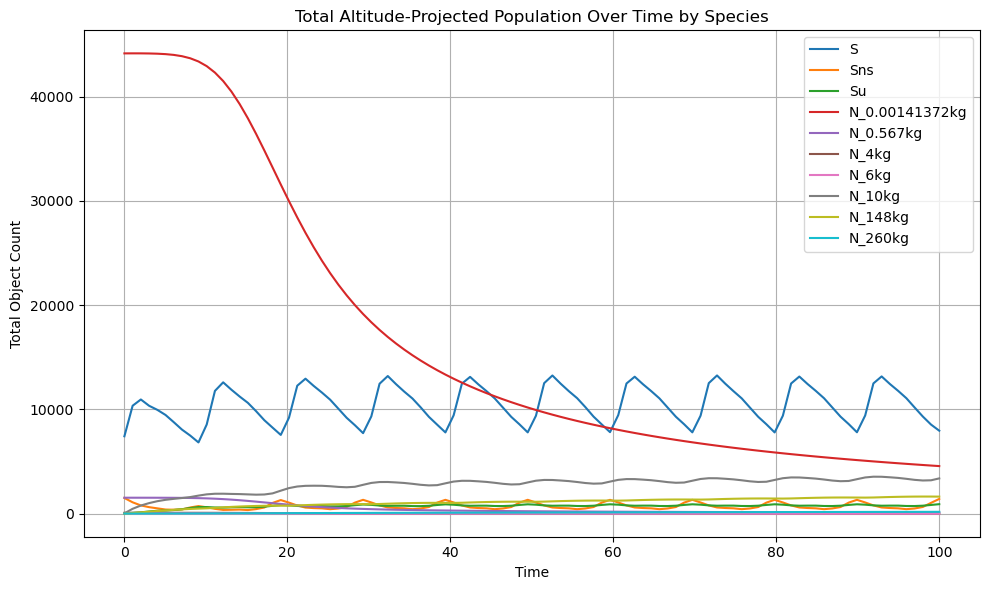

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # (n_shells,)
n_timesteps = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t  # shape: (n_timesteps,)

# --- Initialize storage ---
y = scenario_properties.output.y
species_totals_over_time = np.zeros((n_species, n_timesteps))  # shape: (species, time)

# --- Loop over each time step ---
for t_idx in range(n_timesteps):
    y_t = y[:, t_idx]  # shape: (n_sma_bins * n_species * n_ecc_bins,)
    x_matrix = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))  # reshape to (sma, species, ecc)
    x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)  # shape: (alt_shells, species)

    species_totals_over_time[:, t_idx] = np.sum(x_alt, axis=0)  # total per species

# --- Plot ---
plt.figure(figsize=(10, 6))
for i in range(n_species):
    plt.plot(times, species_totals_over_time[i], label=species_names[i])

plt.xlabel("Time")
plt.ylabel("Total Object Count")
plt.title("Total Altitude-Projected Population Over Time by Species")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# COMPARISON TO MC

## Initial Population

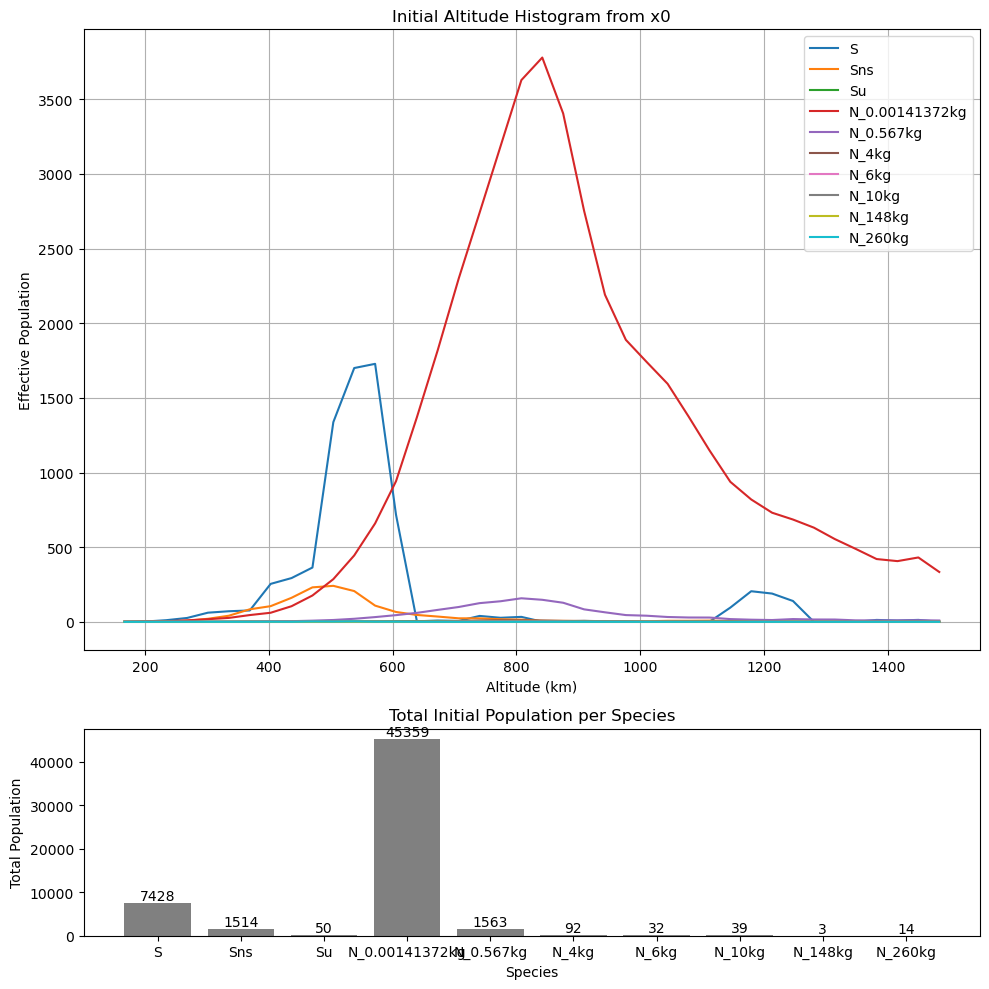

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack inputs
x0 = scenario_properties.x0  # shape: (sma, species, ecc)
TIS = scenario_properties.time_in_shell  # shape: (altitude, ecc, sma)
altitudes = scenario_properties.HMid  # length: n_alt_shells
species_names = scenario_properties.species_names

n_sma_bins, n_species, n_ecc_bins = x0.shape
n_alt_shells = TIS.shape[0]

# --- Calculate effective population in each altitude shell per species ---
effective_altitude_matrix = np.zeros((n_alt_shells, n_species))

for species in range(n_species):
    for alt_shell in range(n_alt_shells):
        total = 0.0
        for sma in range(n_sma_bins):
            for ecc in range(n_ecc_bins):
                n_pop = x0[sma, species, ecc]
                tis = TIS[alt_shell, ecc, sma]
                total += n_pop * tis
        effective_altitude_matrix[alt_shell, species] = total

# --- Calculate total initial population per species ---
total_species_population = x0.sum(axis=(0, 2))

# --- Plot Setup ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

# --- Plot: One line per species (Altitude distribution) ---
for s in range(n_species):
    ax1.plot(altitudes, effective_altitude_matrix[:, s], label=species_names[s])

ax1.set_xlabel("Altitude (km)")
ax1.set_ylabel("Effective Population")
ax1.set_title("Initial Altitude Histogram from x0")
ax1.legend()
ax1.grid(True)

# --- Histogram of total population per species ---
bars = ax2.bar(species_names, total_species_population, color='grey')

ax2.set_xlabel("Species")
ax2.set_ylabel("Total Population")
ax2.set_title("Total Initial Population per Species")

# --- Annotate actual numbers on bars ---
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [24]:
scenario_properties.x0[:, 1, :].sum()

1514

## FLM Difference to MC

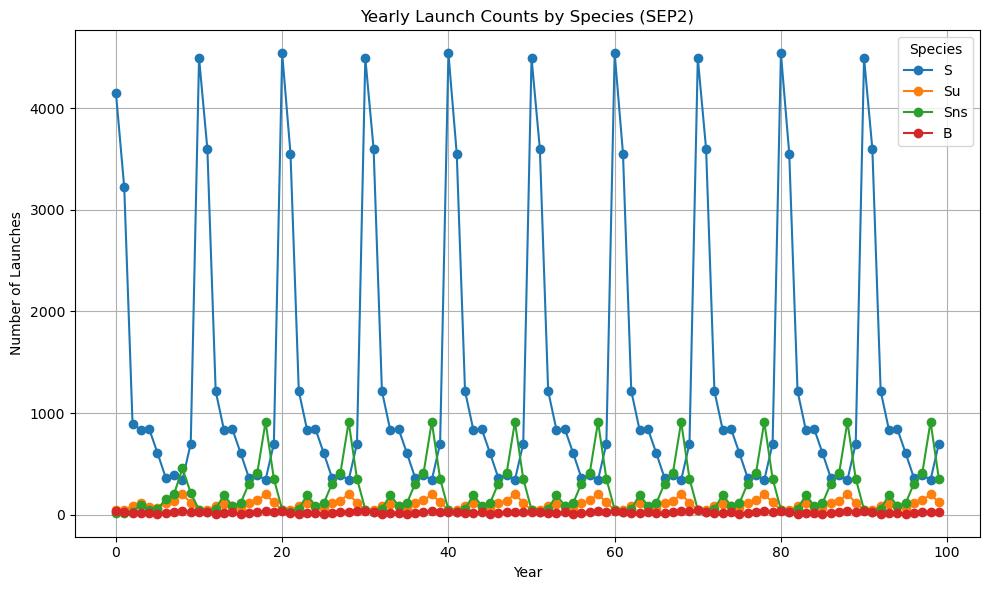

In [25]:
# Load CSV data
df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')

# Filter relevant species
species_of_interest = ['S', 'Su', 'Sns', 'B']
df_filtered = df[df['Species'].isin(species_of_interest)]

# Pivot table to have Years as index and Species as columns
pivot_df = df_filtered.pivot(index='Year', columns='Species', values='Launch_Count')

# Plot comparison
plt.figure(figsize=(10, 6))
for species in species_of_interest:
    if species in pivot_df:
        plt.plot(pivot_df.index, pivot_df[species], marker='o', label=species)

plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Yearly Launch Counts by Species (SEP2)')
plt.legend(title='Species')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# List of species
target_species = ["S", "Sns", "Su", "B"]

# --- pySSEM time series ---
pyss_df = (
    scenario_properties.FLM_steps
    .groupby("epoch_start_date")[target_species]
    .sum()
)
pyss_df.index = pd.to_datetime(pyss_df.index)

# --- MOCAT-MC (SEP2) time series ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_df['Date'] = pd.to_datetime(mc_df['Year'] + 2025, format='%Y')
mc_ts = (
    mc_df.pivot(index='Date', columns='Species', values='Launch_Count')
         .reindex(columns=target_species)
         .sort_index()
)

# --- Align both series on a common index ---
common_index = pyss_df.index.union(mc_ts.index)
pyss = pyss_df.reindex(common_index).fillna(0)
mc   = mc_ts.reindex(common_index).fillna(0)

# --- Compute difference and cumulative sums ---
diff = pyss - mc
cum_pyss = pyss.cumsum()
cum_mc   = mc.cumsum()

# --- Create 4x2 subplot grid ---
fig, axes = plt.subplots(4, 2, figsize=(14, 16), sharex=True)
for i, sp in enumerate(target_species):
    ax_diff = axes[i, 0]
    ax_cum  = axes[i, 1]
    
    # Difference plot
    ax_diff.plot(diff.index, diff[sp], marker='o')
    ax_diff.axhline(0, color='black', linewidth=0.8)
    ax_diff.set_title(f"{sp}: SSEM − MOCAT-MC")
    ax_diff.set_ylabel('Difference')
    ax_diff.grid(True)
    
    # Cumulative plot
    ax_cum.plot(cum_pyss.index, cum_pyss[sp],  label='SSEM')
    ax_cum.plot(cum_mc.index,   cum_mc[sp],   label='MOCAT-MC')
    ax_cum.set_title(f"{sp}: Cumulative Launches")
    ax_cum.legend()
    ax_cum.grid(True)

# Common X label
for ax in axes[-1, :]:
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

# --- Combined cumulative plot for all species ---
plt.figure(figsize=(10, 6))
for sp in target_species:
    plt.plot(cum_pyss.index, cum_pyss[sp],label=f"pySSEM {sp}")
    plt.plot(cum_mc.index,   cum_mc[sp],  linestyle='--', label=f"MOCAT-MC {sp}")

plt.xlabel('Date')
plt.ylabel('Cumulative Launches')
plt.title('Cumulative Launches by Species: pySSEM vs MOCAT-MC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: "Columns not found: 'B'"

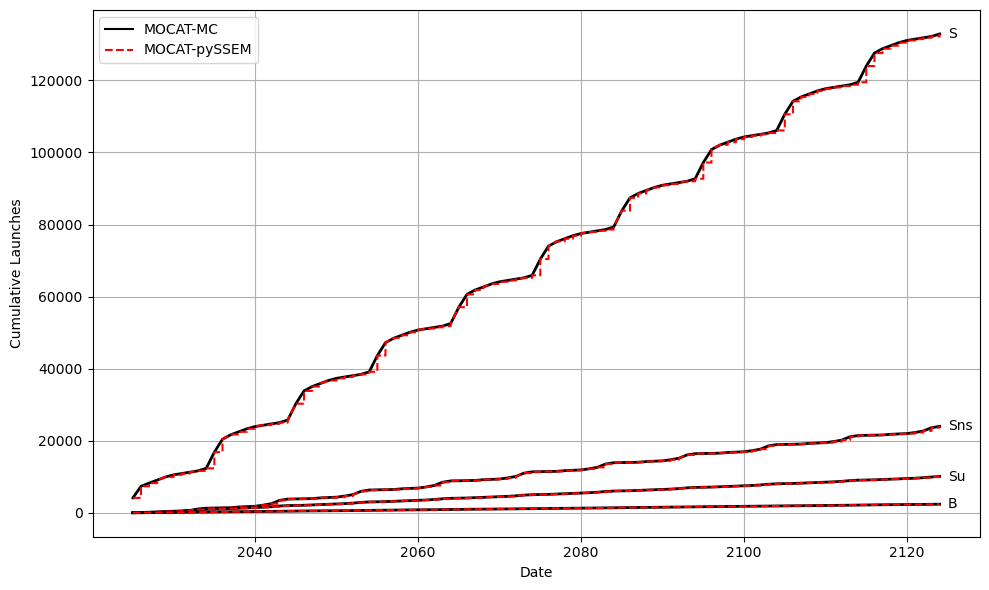

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# List of species
target_species = ["S", "Sns", "Su", "B"]

# --- pySSEM time series ---
pyss_df = (
    scenario_properties.FLM_steps
    .groupby("epoch_start_date")[target_species]
    .sum()
)
pyss_df.index = pd.to_datetime(pyss_df.index)

# --- MOCAT-MC (SEP2) time series ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_df['Date'] = pd.to_datetime(mc_df['Year'] + 2025, format='%Y')
mc_ts = (
    mc_df.pivot(index='Date', columns='Species', values='Launch_Count')
         .reindex(columns=target_species)
         .sort_index()
)

# --- Align both series ---
common_index = pyss_df.index.union(mc_ts.index)
pyss = pyss_df.reindex(common_index).fillna(0)
mc   = mc_ts.reindex(common_index).fillna(0)

# --- Compute cumulative sums ---
cum_pyss = pyss.cumsum()
cum_mc   = mc.cumsum()

# --- Combined cumulative plot ---
plt.figure(figsize=(10, 6))

# Model-level colors
py_color = 'red'
mc_color = 'black'

for sp in target_species:
    # MOCAT-MC solid thick
    plt.plot(cum_mc.index, cum_mc[sp],
             linestyle='-', linewidth = 2, color=mc_color)
        # pySSEM dashed
    plt.plot(cum_pyss.index, cum_pyss[sp],
             linestyle='--', color=py_color)

# Annotate species names at final point (using MOCAT-MC values)
x_last = cum_mc.index[-1] + pd.Timedelta(days=365)  # offset 1 year to the right
for sp in target_species:
    y_last = cum_mc[sp].iloc[-1]
    plt.text(x_last, y_last, sp, va='center')

# Legend with only model names
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color=mc_color, label='MOCAT-MC'),
    Line2D([0], [0], color=py_color, linestyle='--', label='MOCAT-pySSEM')
]
plt.legend(handles=legend_handles, loc='upper left')

plt.xlabel('Date')
plt.ylabel('Cumulative Launches')
# plt.title('Cumulative Launches by Species')
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
plt.show()

## Difference with Np.interp

In [ ]:
import pandas as pd

# List of species
target_species = ["S", "Sns", "Su", "B"]

# --- pySSEM time series ---
pyss_df = (
    scenario_properties.FLM_steps
    .groupby("epoch_start_date")[target_species]
    .sum()
)
pyss_df.index = pd.to_datetime(pyss_df.index)

# --- MOCAT-MC (SEP2) time series ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_df['Date'] = pd.to_datetime(mc_df['Year'] + 2025, format='%Y')
mc_ts = (
    mc_df.pivot(index='Date', columns='Species', values='Launch_Count')
         .reindex(columns=target_species)
         .sort_index()
)

# --- Align both series on a common index ---
common_index = pyss_df.index.union(mc_ts.index)
pyss = pyss_df.reindex(common_index).fillna(0)
mc   = mc_ts.reindex(common_index).fillna(0)

# --- Compute difference and cumulative sums by species ---
diff       = pyss - mc
cum_diff   = diff.cumsum()

# --- Total cumulative difference across species at each time ---
total_cum_diff = cum_diff.sum(axis=1)

# --- Final cumulative difference over entire scenario ---
final_diff = total_cum_diff.iloc[-1]
print(f"Cumulative difference (pySSEM − MOCAT-MC) at end of scenario: {final_diff}")

# Optional: cumulative difference time series
# total_cum_diff.plot(title='Total Cumulative Difference Over Time')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Difference')
# plt.grid(True)
# plt.show()

Cumulative difference (pySSEM − MOCAT-MC) at end of scenario: 27.0


# OVerall Population Difference SSEM/MC

In [2]:
scenario_properties.species_names

['S',
 'Su',
 'N_0.00141372kg',
 'N_0.567kg',
 'N_4kg',
 'N_6kg',
 'N_148kg',
 'N_260kg',
 'B']

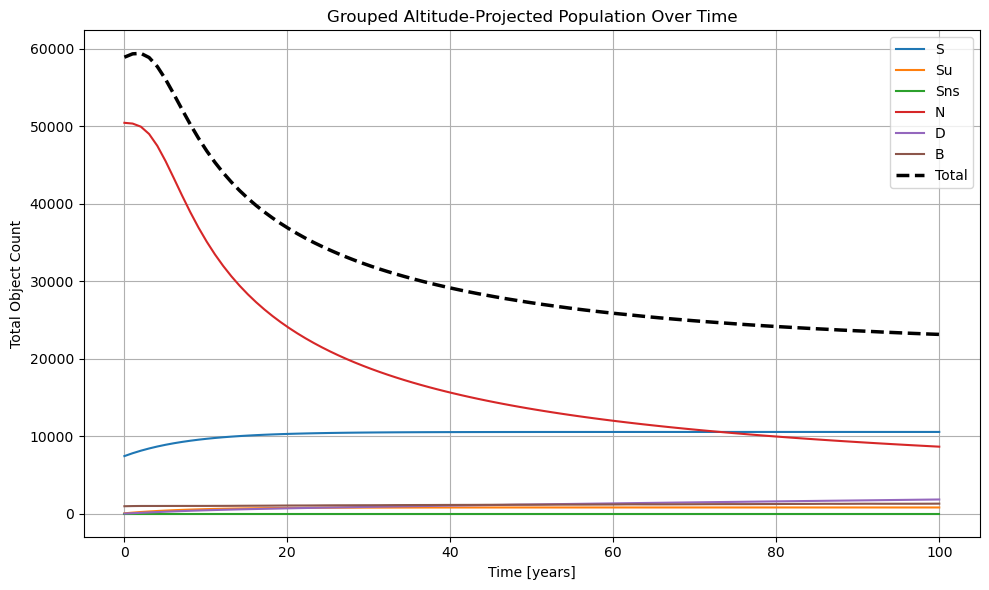

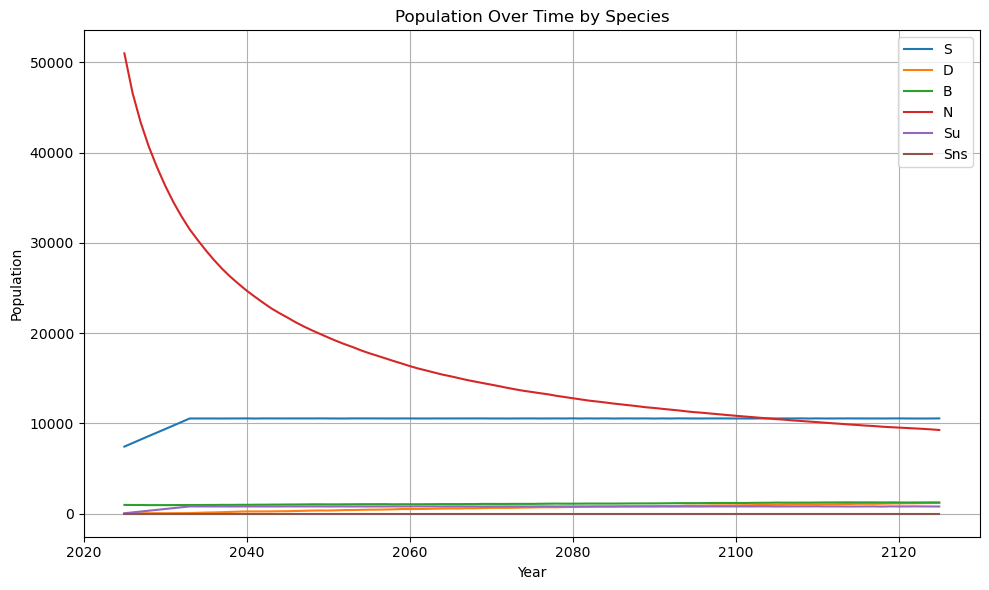

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid
n_timesteps = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t

# --- Initialize storage ---
y = scenario_properties.output.y
species_totals_over_time = np.zeros((n_species, n_timesteps))

# --- Project and sum over altitudes ---
for t_idx in range(n_timesteps):
    y_t = y[:, t_idx]
    x_matrix = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))
    x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)
    species_totals_over_time[:, t_idx] = np.sum(x_alt, axis=0)

# --- Define groupings ---
large_fragments = ['N_10kg', 'N_148kg', 'N_260kg', 'N_472kg', 'N_750kg', 'N_1250kg']
group_indices = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N': [i for i, sp in enumerate(species_names)
        if sp.startswith('N') and sp not in large_fragments],
    'D': [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp == 'B']
}

# --- Compute grouped totals ---
group_totals = {group: np.sum(species_totals_over_time[indices], axis=0)
                for group, indices in group_indices.items()}

# --- Plot ---
plt.figure(figsize=(10, 6))
for group, values in group_totals.items():
    plt.plot(times, values, label=group)
plt.plot(times, np.sum(species_totals_over_time, axis=0), label="Total", linewidth=2.5, linestyle='--', color='black')

plt.xlabel("Time [years]")
plt.ylabel("Total Object Count")
plt.title("Grouped Altitude-Projected Population Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# load the MOCAT-MC data
import pandas as pd

mc_launch = '/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv'
mc_pop_time_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time.csv'
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'

mc_pop_time = pd.read_csv(mc_pop_time_path)

plt.figure(figsize=(10, 6))
for species in mc_pop_time["Species"].unique():
    species_df = mc_pop_time[mc_pop_time["Species"] == species]
    plt.plot(species_df["Year"], species_df["Population"], label=species)

plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Population Over Time by Species")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
plt.show()

In [4]:
scenario_properties.x0[:, 1, :].sum()

50

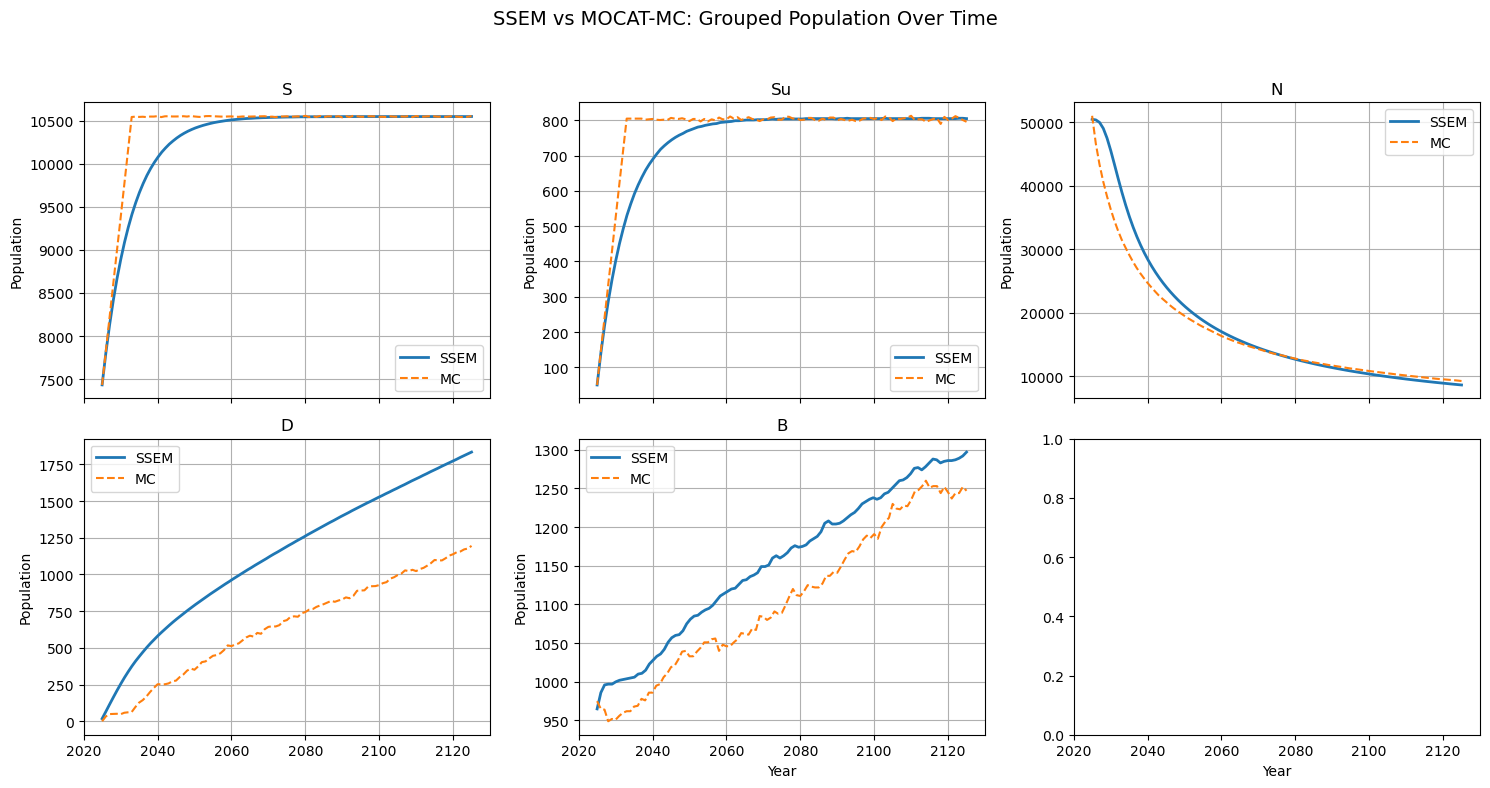

In [18]:
import matplotlib.pyplot as plt

# --- Species groups to compare ---
# species_groups = ['S', 'Su', 'Sns', 'N', 'D_S', 'D_Su', 'D_Sns', 'B', 'D']
species_groups = ['S', 'Su',  'N', 'D', 'B']
n_rows, n_cols = 2, 3

start_year = 2025  # Or derive from scenario_properties.start_date
ssem_years = times + start_year

# --- Create subplot grid ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharex=True)
axes = axes.flatten()

for idx, group in enumerate(species_groups):
    ax = axes[idx]
    
    # Plot SSEM
    if group in group_totals:
        ax.plot(ssem_years, group_totals[group].round(), label='SSEM', linewidth=2)

    # Plot MOCAT-MC
    if group in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == group]
        ax.plot(mc_df["Year"], mc_df["Population"], '--', label='MC', linewidth=1.5)

    ax.set_title(group)
    ax.set_ylabel("Population")
    ax.grid(True)
    ax.legend()

# Add shared X labels
axes[-2].set_xlabel("Year")
axes[-1].set_xlabel("Year")

plt.suptitle("SSEM vs MOCAT-MC: Grouped Population Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.ticklabel_format(useOffset=False, axis='y')
# plt.xlim(2025,2045)
plt.show()

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_7181/4092129622.py:31: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = ssem_df.merge(mc_df, on="Year", how="inner")
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_7181/4092129622.py:31: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = ssem_df.merge(mc_df, on="Year", how="inner")
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_7181/4092129622.py:31: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = ssem_df.merge(mc_df, on="Year", how="inner")


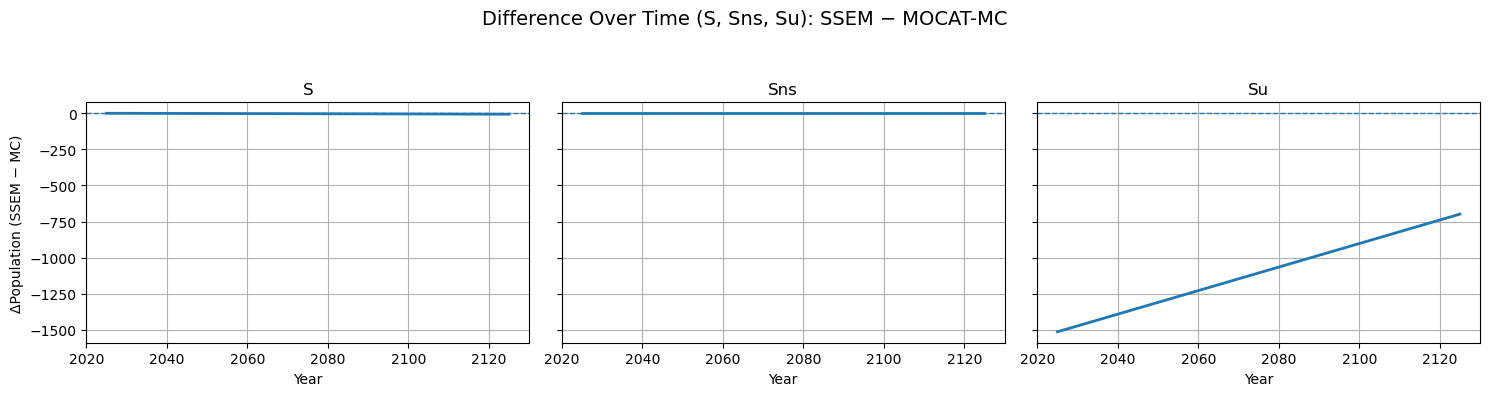

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

diff_groups = ['S', 'Sns', 'Su']
fig_diff, axes_diff = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

for i, grp in enumerate(diff_groups):
    ax = axes_diff[i]

    if (grp in group_totals) and (grp in mc_pop_time["Species"].unique()):
        # Build SSEM dataframe
        ssem_df = pd.DataFrame({
            "Year": ssem_years,
            "SSEM": np.asarray(group_totals[grp], float)
        })

        # Build MC dataframe (dedupe by Year)
        mc_df = (mc_pop_time[mc_pop_time["Species"] == grp][["Year", "Population"]]
                 .rename(columns={"Population": "MC"})
                 .sort_values("Year")
                 .drop_duplicates(subset="Year", keep="last"))

        # If both are effectively integers, align on int years (optional convenience)
        if np.allclose(ssem_df["Year"].values, np.round(ssem_df["Year"].values)):
            ssem_df["Year"] = ssem_df["Year"].round().astype(int)
        if np.issubdtype(mc_df["Year"].dtype, np.floating) and np.allclose(mc_df["Year"], np.round(mc_df["Year"])):
            mc_df["Year"] = mc_df["Year"].round().astype(int)

        # Strict overlap only
        merged = ssem_df.merge(mc_df, on="Year", how="inner")

        if merged.empty:
            ax.set_title(f"{grp} (no overlapping years)")
            ax.grid(True)
            continue

        diff = merged["SSEM"] - merged["MC"]
        ax.plot(merged["Year"], diff, linewidth=2)
        ax.axhline(0, linestyle='--', linewidth=1)
        ax.set_title(grp)
        ax.grid(True)
    else:
        ax.set_title(f"{grp} (no data)")
        ax.grid(True)

axes_diff[0].set_ylabel("ΔPopulation (SSEM − MC)")
for ax in axes_diff:
    ax.set_xlabel("Year")

fig_diff.suptitle("Difference Over Time (S, Sns, Su): SSEM − MOCAT-MC", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

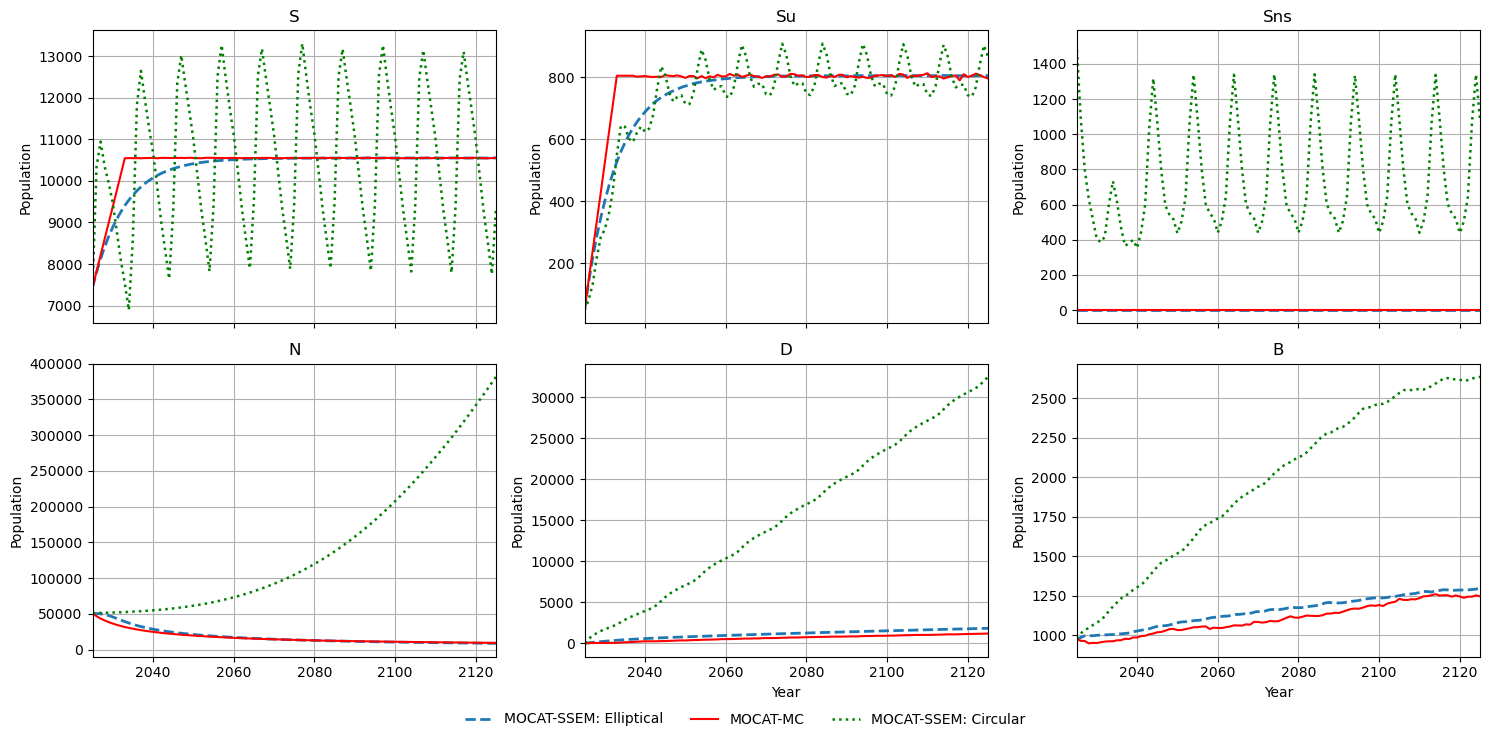

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load third dataset: SSEM-Old ---
ssem_old_path = "/Users/indigobrownhall/Code/pyssem/figures/SEP-Final-Runs/SEP2/pop_time.csv"
df_ssem_old = pd.read_csv(ssem_old_path)
df_ssem_old = df_ssem_old[df_ssem_old["Year"] <= 2125]

species_groups = ['S', 'Su', 'Sns', 'N', 'D', 'B']
n_rows, n_cols = 2, 3

# --- Time adjustment for SSEM (assumes you have `times` and `group_totals` defined) ---
start_year = 2025
ssem_years = times + start_year

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharex=True)
axes = axes.flatten()

for idx, group in enumerate(species_groups):
    ax = axes[idx]
    
    # Plot SSEM (new)
    if group in group_totals:
        ax.plot(ssem_years, group_totals[group],
                '--',
                label='MOCAT-SSEM: Elliptical', linewidth=2)

    # Plot MC
    if group in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == group]
        ax.plot(mc_df["Year"], mc_df["Population"],
                '-', label='MOCAT-MC', linewidth=1.5, color='red')

    # Plot SSEM-Old
    if group in df_ssem_old["Species"].unique():
        old_df = df_ssem_old[df_ssem_old["Species"] == group]
        ax.plot(old_df["Year"], old_df["Population"], 
                ':', label='MOCAT-SSEM: Circular', color='green', linewidth=1.8)

    ax.set_title(group)
    ax.set_ylabel("Population")
    ax.grid(True)
    # DON'T call ax.legend() here!

# Shared X labels
axes[-2].set_xlabel("Year")
axes[-1].set_xlabel("Year")

# Adjust layout so there's room at the bottom for the legend
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Collect all handles & labels from all axes
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:          # avoid duplicates
            handles.append(h)
            labels.append(l)

# Single legend at the bottom, one row
fig.legend(handles, labels,
           loc='lower center',
           ncol=len(labels),
           frameon=False,
           bbox_to_anchor=(0.5, 0.02))

# Set x-limits and show
plt.xlim(2025, 2125)
plt.show()

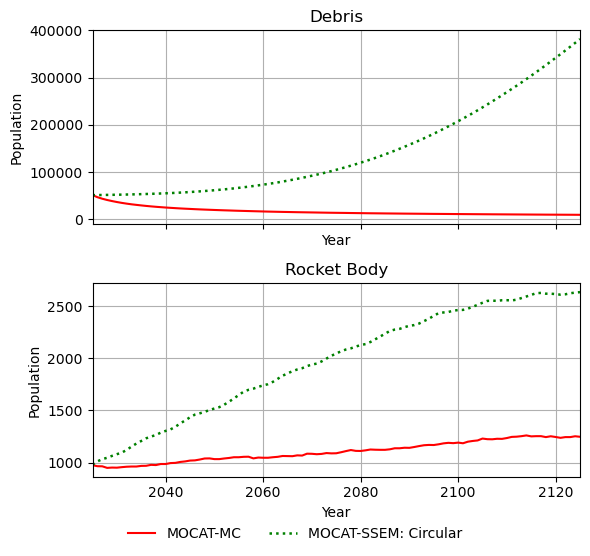

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load third dataset: SSEM-Old ---
ssem_old_path = "/Users/indigobrownhall/Code/pyssem/figures/SEP-Final-Runs/SEP2/pop_time.csv"
df_ssem_old = pd.read_csv(ssem_old_path)
df_ssem_old = df_ssem_old[df_ssem_old["Year"] <= 2125]

# species_groups = ['S', 'Su', 'Sns', 'N', 'D', 'B']
species_groups = ['N', 'B']
n_rows, n_cols = 2, 1

# --- Time adjustment for SSEM (assumes you have `times` and `group_totals` defined) ---
start_year = 2025
ssem_years = times + start_year

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6), sharex=True)
axes = axes.flatten()

for idx, group in enumerate(species_groups):
    ax = axes[idx]
    
    # # Plot SSEM (new)
    # if group in group_totals:
    #     ax.plot(ssem_years, group_totals[group],
    #             '--',
    #             label='MOCAT-SSEM: Elliptical', linewidth=2)

    # Plot MC
    if group in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == group]
        ax.plot(mc_df["Year"], mc_df["Population"],
                '-', label='MOCAT-MC', linewidth=1.5, color='red')

    # Plot SSEM-Old
    if group in df_ssem_old["Species"].unique():
        old_df = df_ssem_old[df_ssem_old["Species"] == group]
        ax.plot(old_df["Year"], old_df["Population"], 
                ':', label='MOCAT-SSEM: Circular', color='green', linewidth=1.8)

    if group == 'N':
        ax.set_title("Debris")
    if group == 'B':
        ax.set_title("Rocket Body")
    ax.set_ylabel("Population")
    ax.grid(True)
    # DON'T call ax.legend() here!

# Shared X labels
axes[-2].set_xlabel("Year")
axes[-1].set_xlabel("Year")

# Adjust layout so there's room at the bottom for the legend
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Collect all handles & labels from all axes
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:          # avoid duplicates
            handles.append(h)
            labels.append(l)

# Single legend at the bottom, one row
fig.legend(handles, labels,
           loc='lower center',
           ncol=len(labels),
           frameon=False,
           bbox_to_anchor=(0.5, 0.02))

# Set x-limits and show
plt.xlim(2025, 2125)
plt.show()

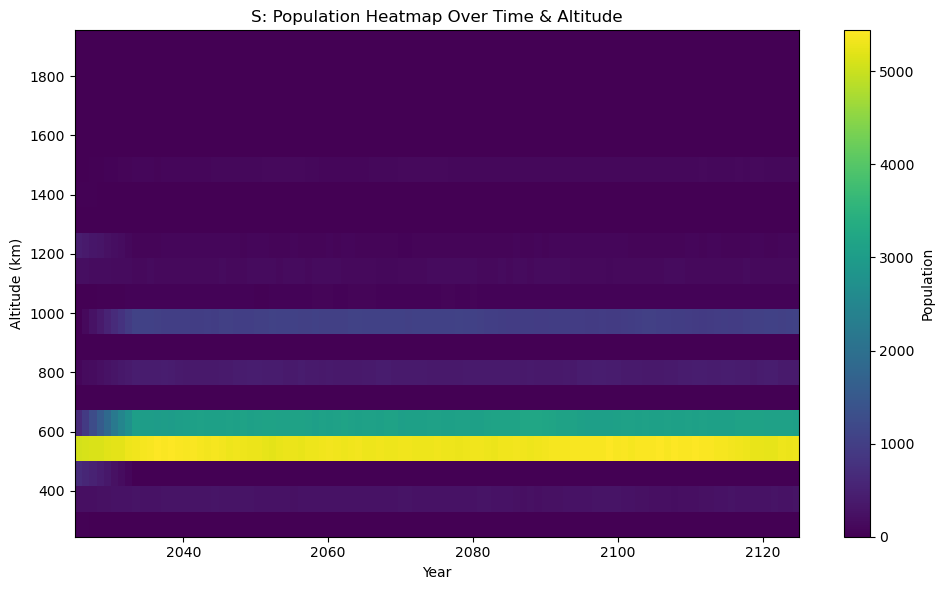

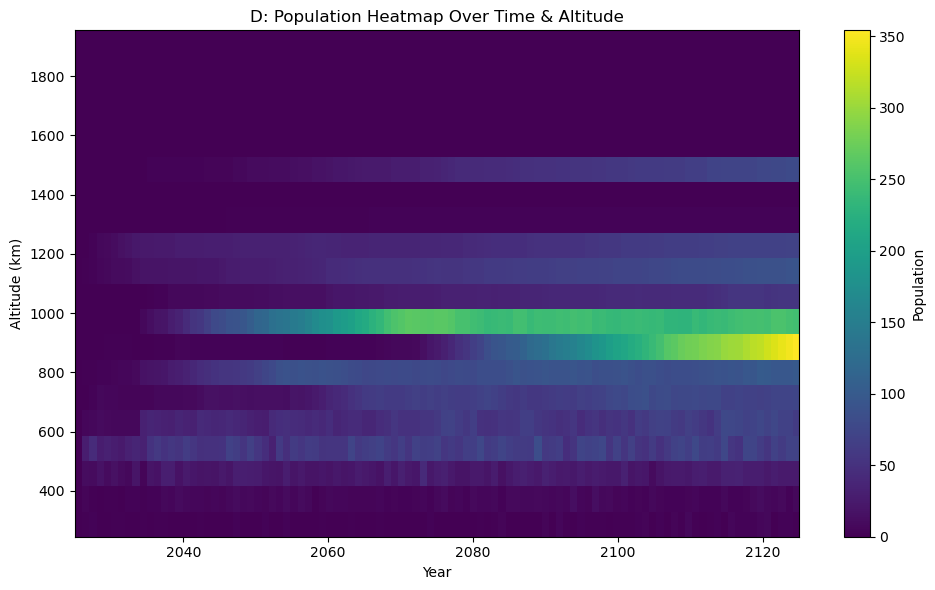

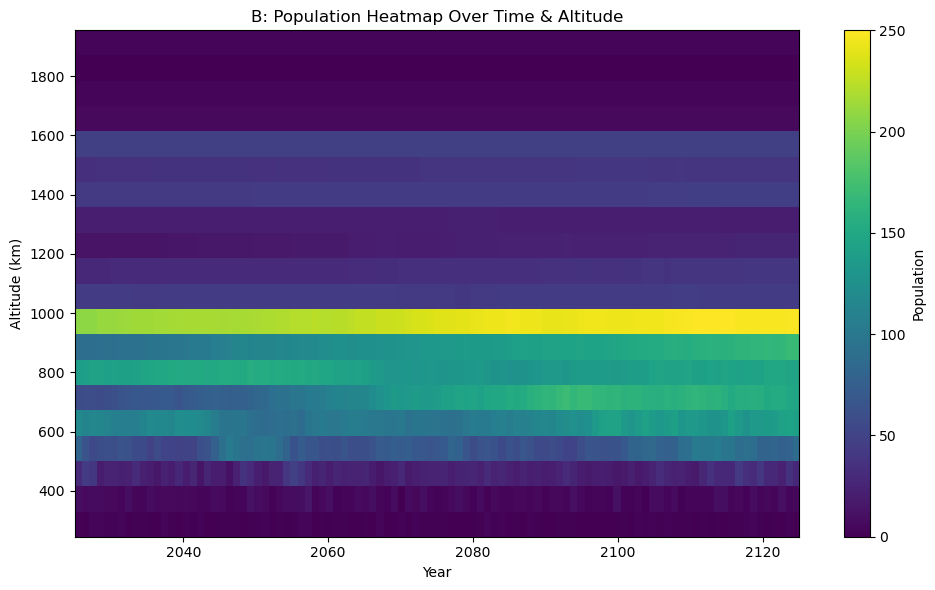

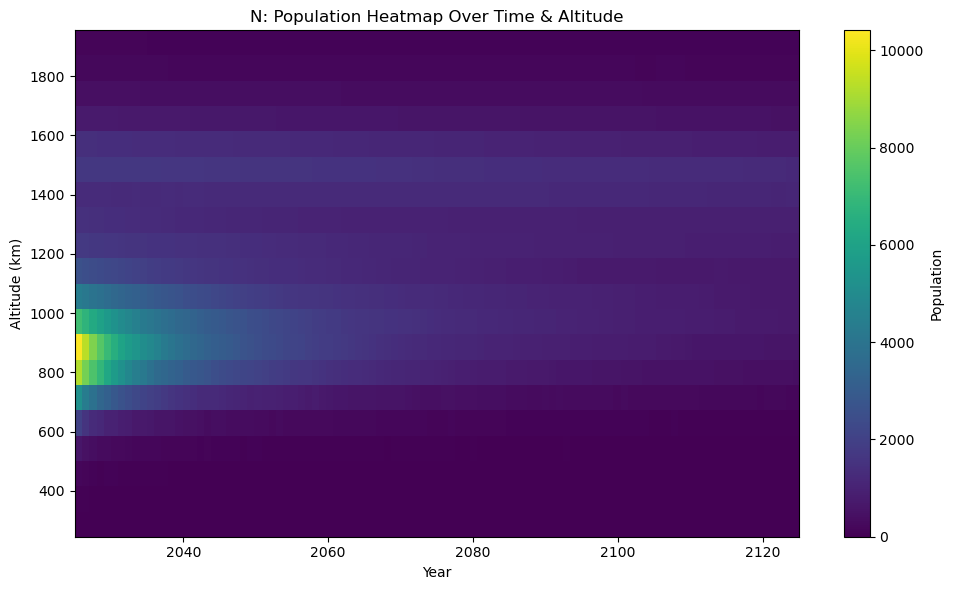

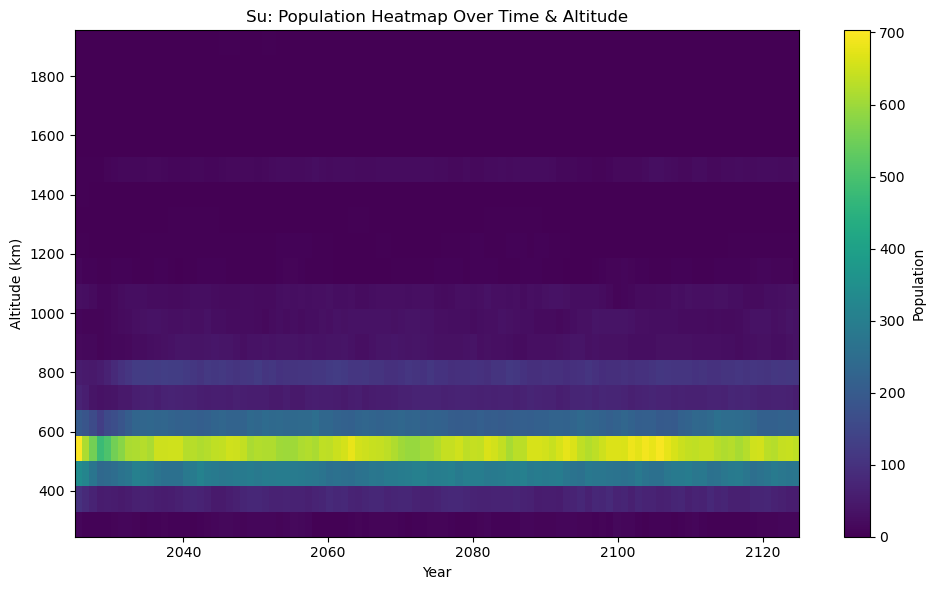

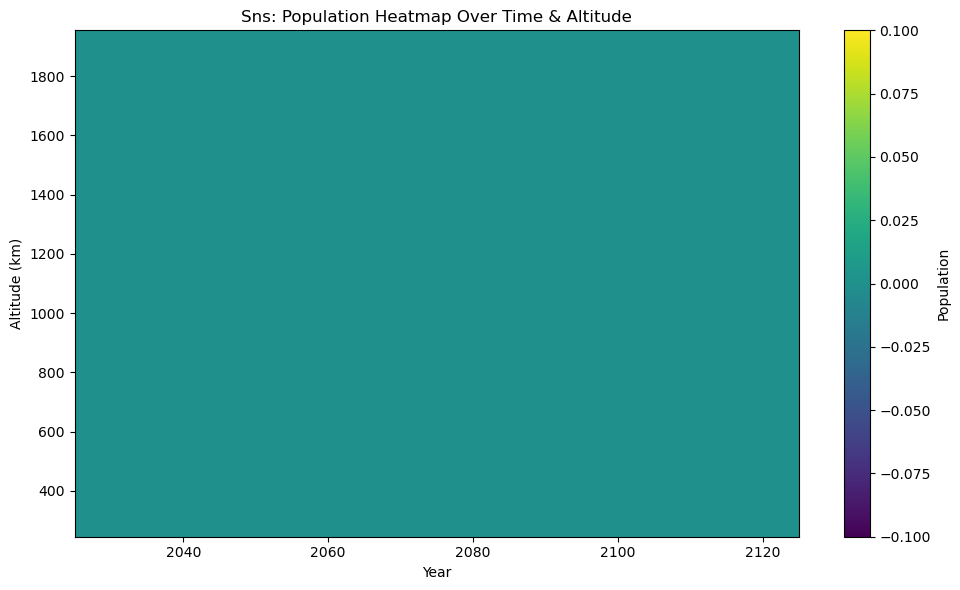

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Path to your altitude‐time data (make sure this points to your correct file)
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'

# --- Load the data ---
df = pd.read_csv(mc_pop_time_alt_path)

# --- For each species, pivot into (altitude × year) and plot ---
for species in df["Species"].unique():
    sp_df = df[df["Species"] == species]
    
    # Create a pivot table: rows=Altitude, cols=Year, values=Population
    pivot = sp_df.pivot(index="Altitude", columns="Year", values="Population")
    
    # Extract sorted axes
    altitudes = pivot.index.values
    years     = pivot.columns.values
    data      = pivot.values  # shape (n_altitude_bins, n_years)
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    im = plt.imshow(
        data,
        aspect='auto',
        origin='lower',
        extent=[years.min(), years.max(), altitudes.min(), altitudes.max()],
        cmap='viridis'
    )
    plt.title(f"{species}: Population Heatmap Over Time & Altitude")
    plt.xlabel("Year")
    plt.ylabel("Altitude (km)")
    plt.colorbar(im, label="Population")
    plt.tight_layout()
    plt.show()

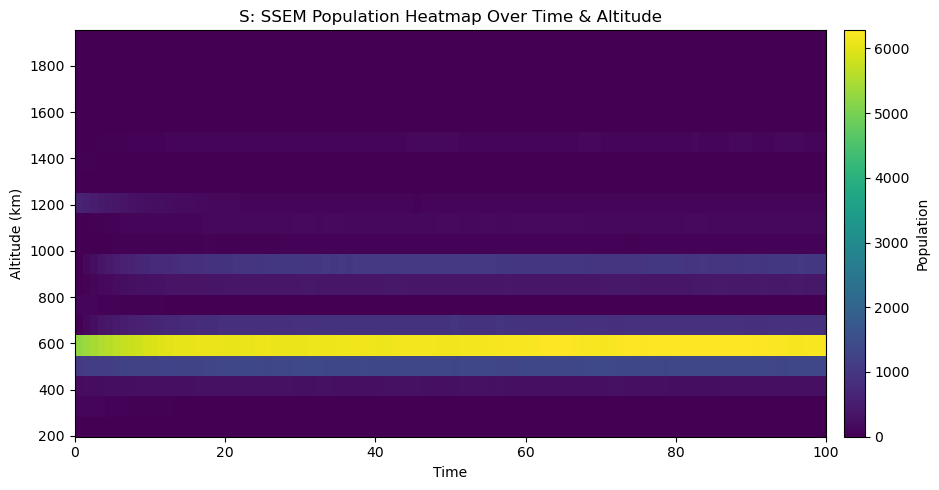

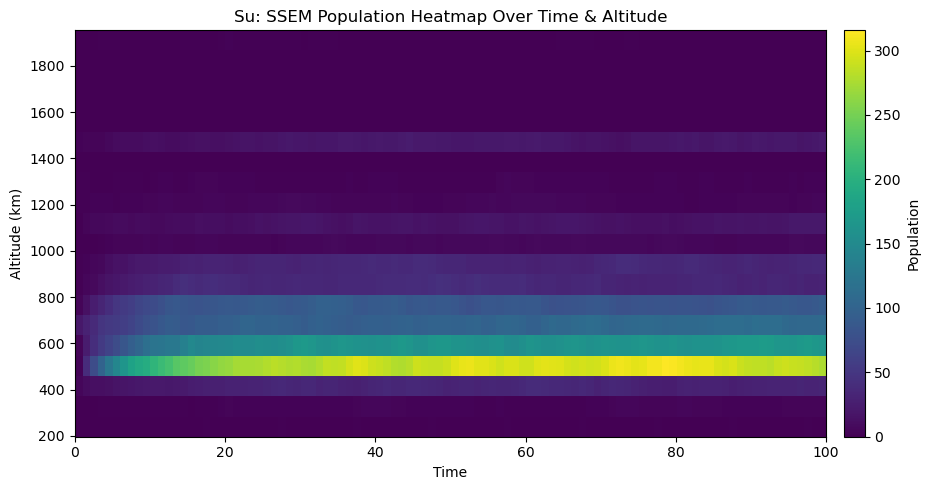

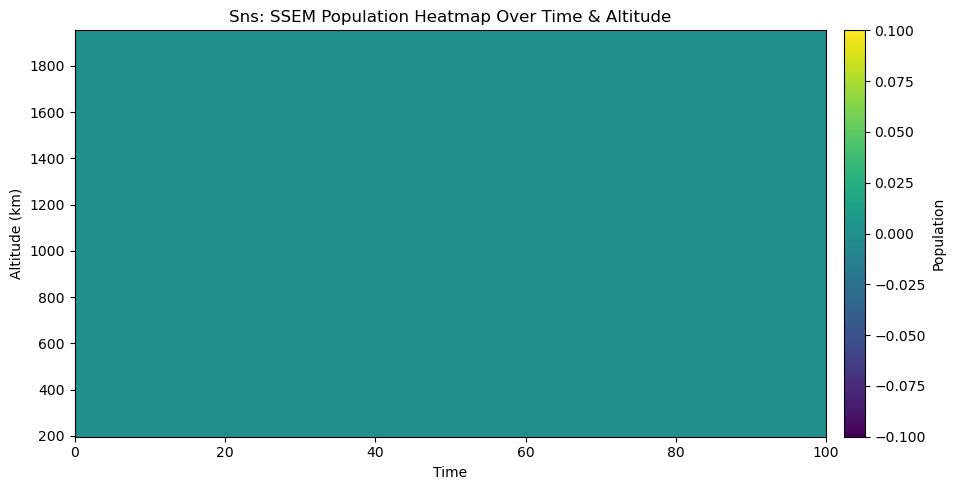

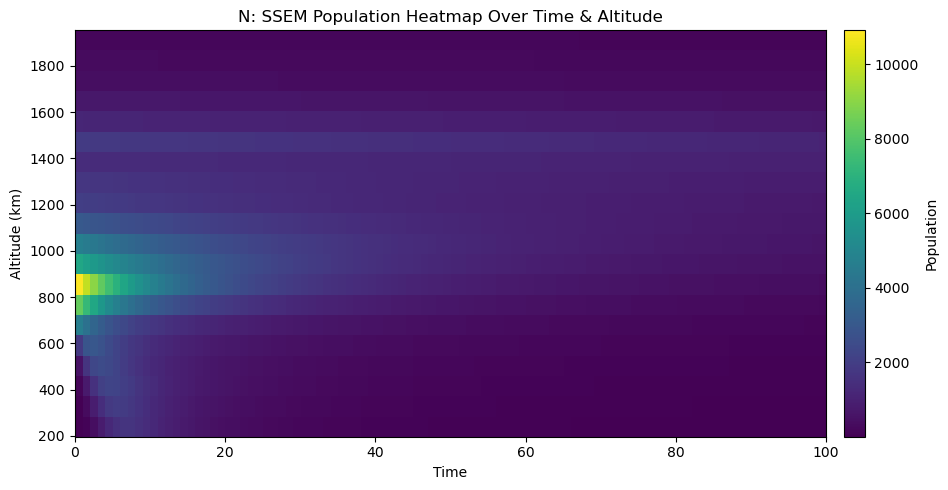

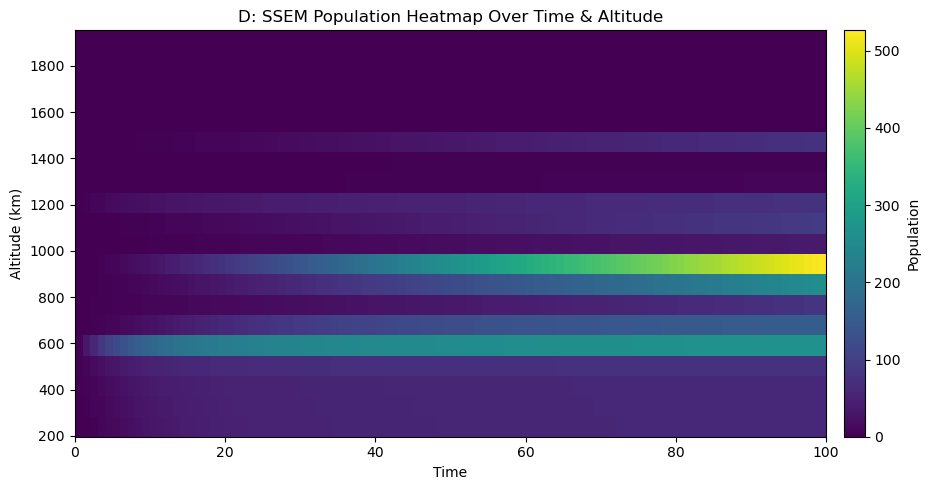

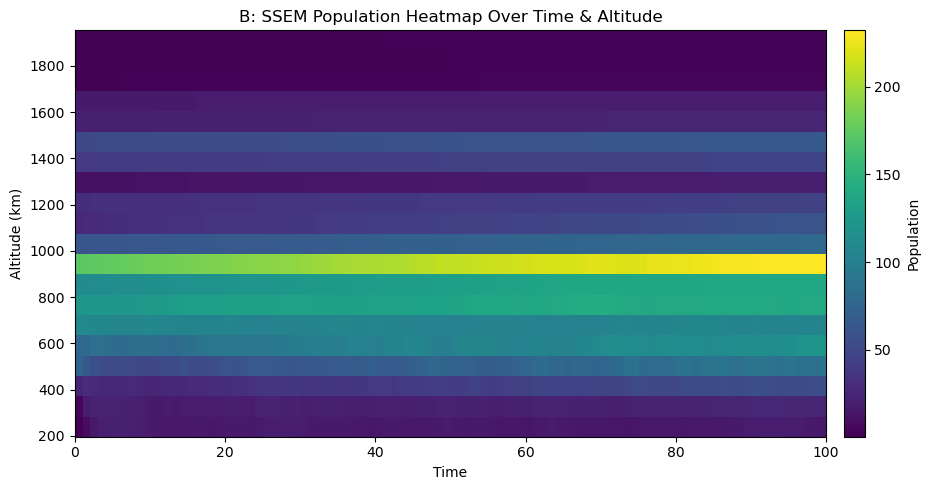

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions & data (SSEM) ---
n_sma_bins    = scenario_properties.n_shells
n_ecc_bins    = len(scenario_properties.eccentricity_bins) - 1
n_species     = scenario_properties.species_length
n_time        = scenario_properties.output.y.shape[1]
times         = scenario_properties.output.t
altitudes     = scenario_properties.HMid            # Altitude midpoints (km)
species_names = scenario_properties.species_names

# --- Define your “main‐species” groupings ---
large_fragments = ['N_10kg', 'N_148kg', 'N_260kg', 'N_472kg', 'N_750kg', 'N_1250kg']
group_indices = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N':   [i for i, sp in enumerate(species_names)
            if sp.startswith('N') and sp not in large_fragments],
    'D':   [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp == 'B']
}

# --- Preallocate storage: one alt×time matrix per group ---
group_n_eff_time = {
    grp: np.zeros((len(altitudes), n_time))
    for grp in group_indices
}

# --- Fill in each group's matrix over time ---
for t in range(n_time):
    # reshape the population vector at time t
    y_t      = scenario_properties.output.y[:, t]
    x_matrix = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))
    
    # project to altitude shells: shape (n_alt_shells, n_species)
    alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)
    
    # sum across species for each group
    for grp, idxs in group_indices.items():
        # sum the columns corresponding to this group's species
        group_n_eff_time[grp][:, t] = alt_proj[:, idxs].sum(axis=1)

# --- Plot heatmap per group ---
for grp, data in group_n_eff_time.items():
    plt.figure(figsize=(10, 5))
    im = plt.imshow(
        data,
        aspect='auto',
        origin='lower',
        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
        cmap='viridis'
    )
    plt.title(f"{grp}: SSEM Population Heatmap Over Time & Altitude")
    plt.xlabel("Time")
    plt.ylabel("Altitude (km)")
    cbar = plt.colorbar(im, pad=0.02)
    cbar.set_label("Population")
    plt.tight_layout()
    plt.show()

In [10]:
scenario_properties.binE_ecc_mid_point

array([0.00573684, 0.01671053, 0.02718421, 0.03765789, 0.04813158,
       0.05860526, 0.06907895, 0.07955263, 0.09002632, 0.1005    ,
       0.11097368, 0.12144737, 0.13192105, 0.14239474, 0.15286842,
       0.16334211, 0.17381579, 0.18428947, 0.59476316])

In [11]:
scenario_properties.sma_HMid_km

array([6574.3866, 6666.8866, 6759.3866, 6851.8866, 6944.3866, 7036.8866,
       7129.3866, 7221.8866, 7314.3866, 7406.8866, 7499.3866, 7591.8866,
       7684.3866, 7776.8866, 7869.3866, 7961.8866, 8054.3866, 8146.8866,
       8239.3866, 8331.8866])

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_7181/4065527319.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


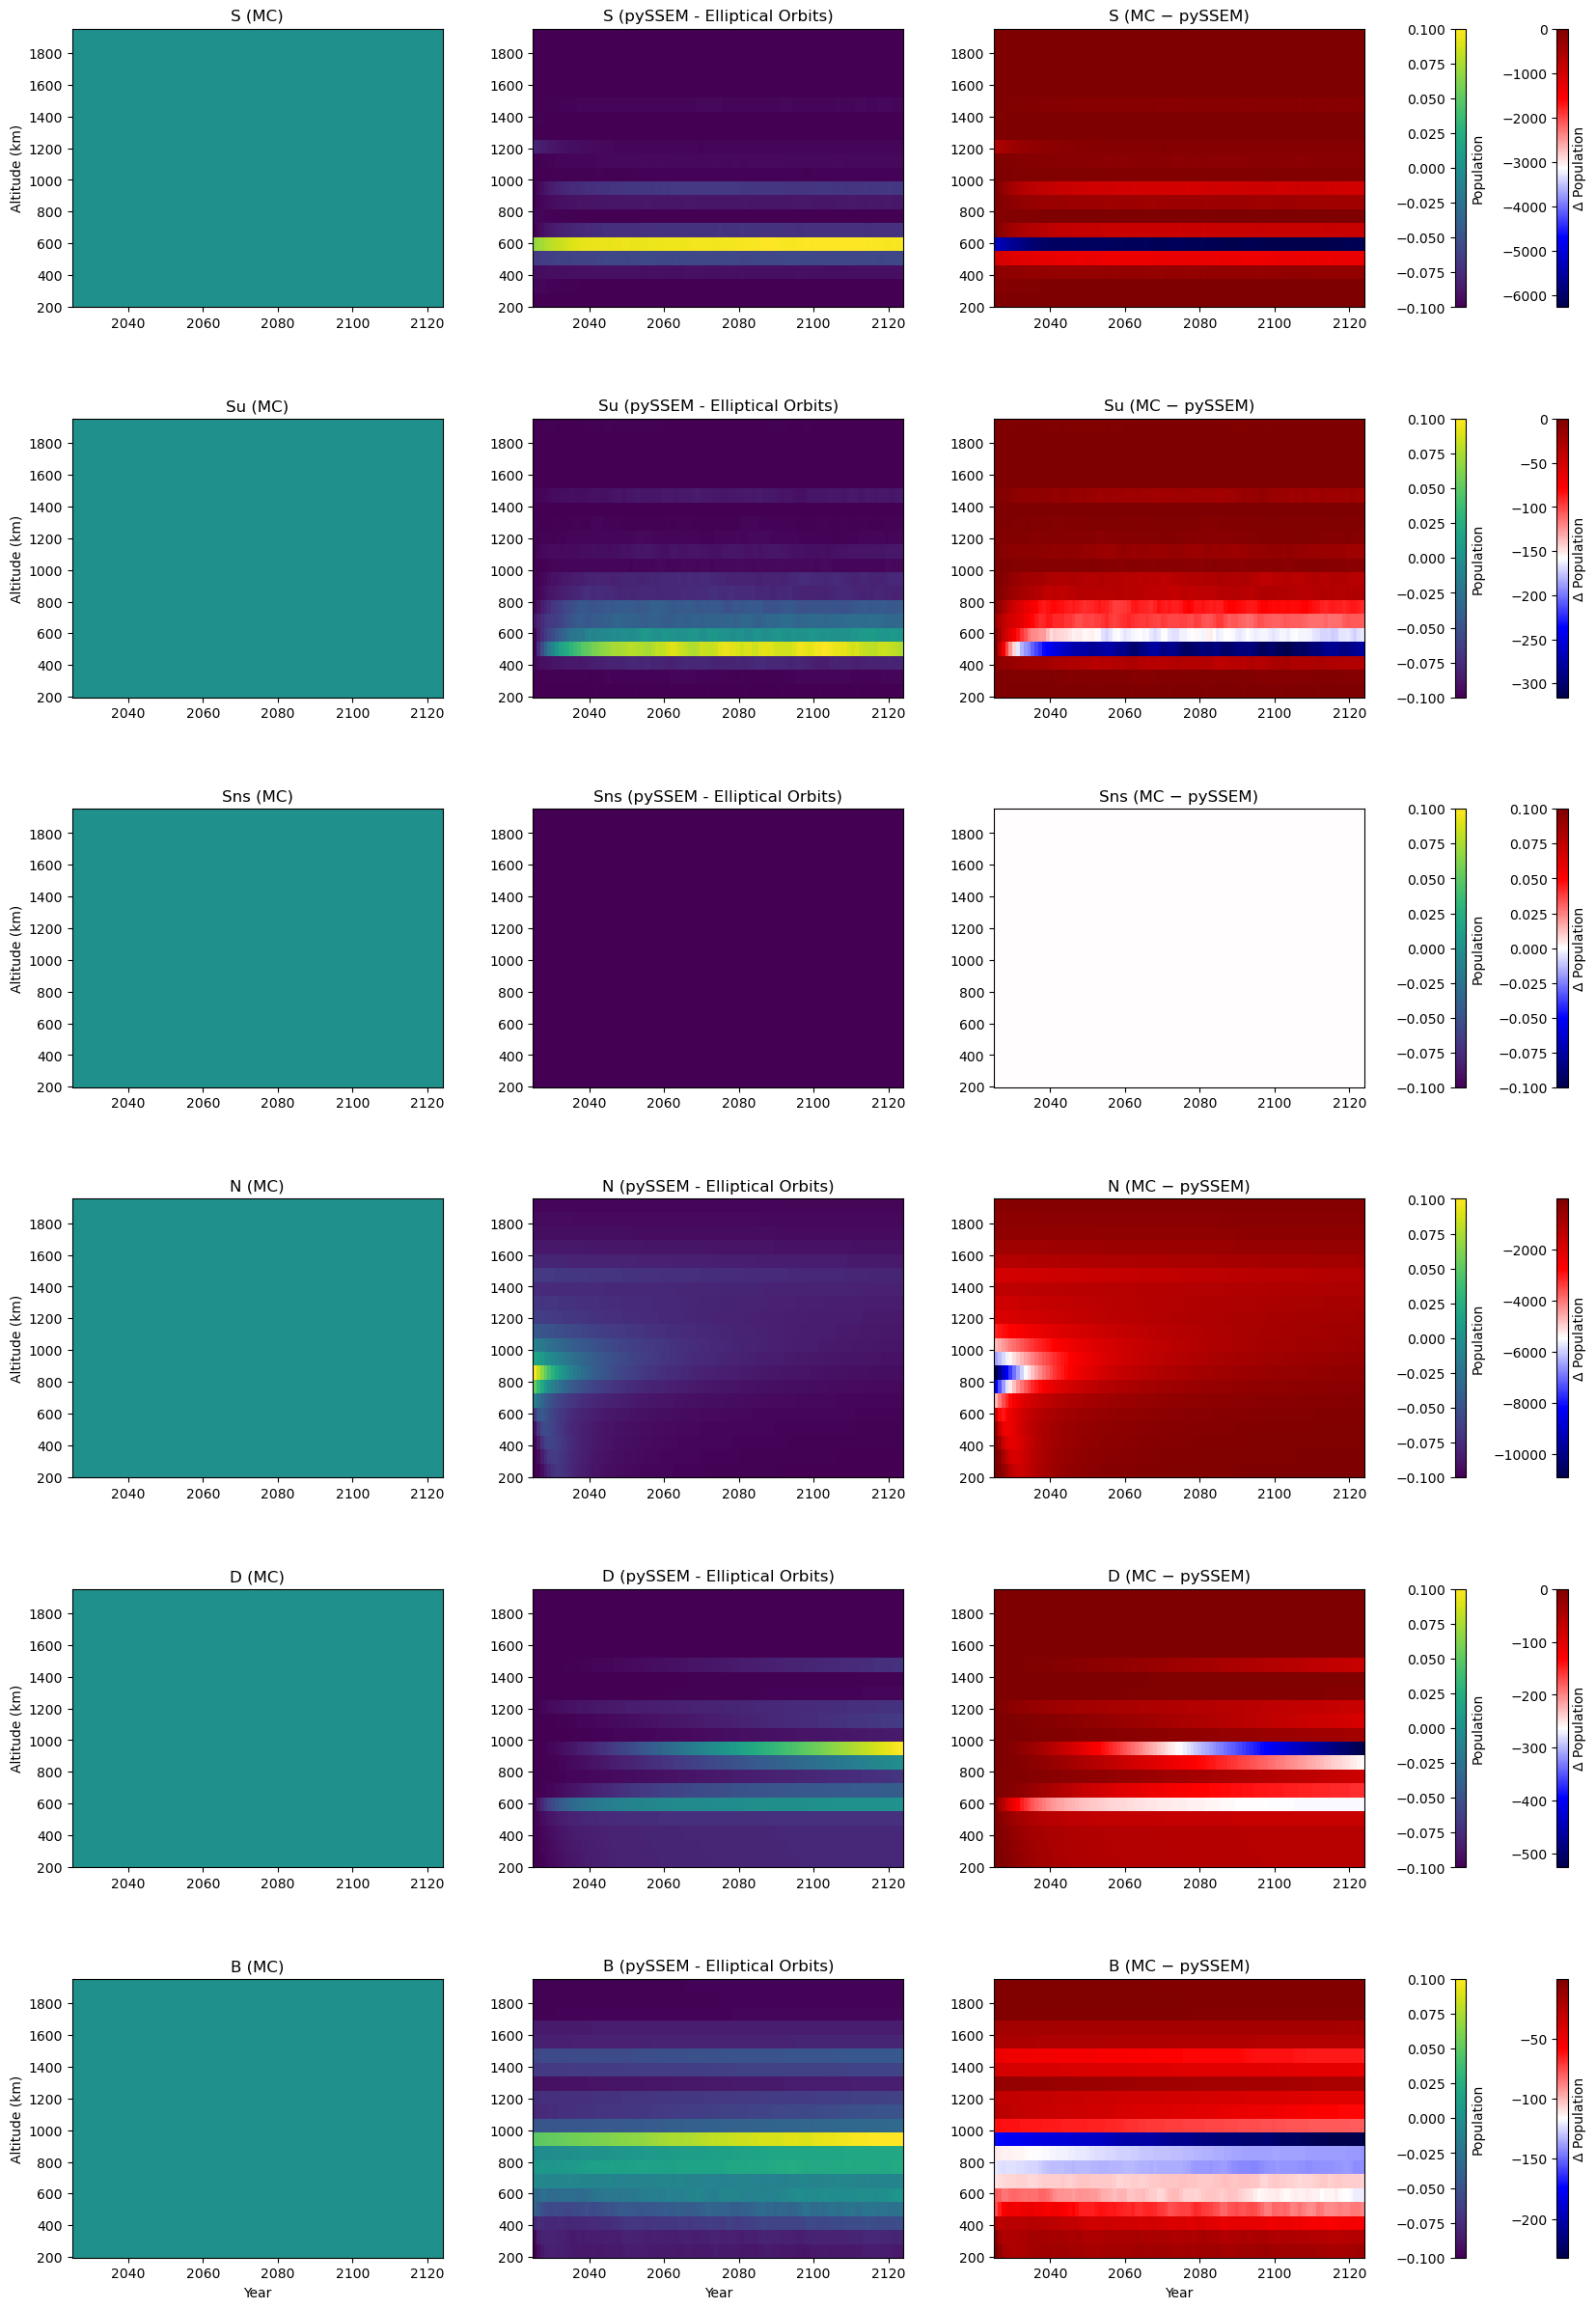

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# — Load MC data —
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'
mc_df = pd.read_csv(mc_pop_time_alt_path)

# — SSEM metadata —
n_sma_bins    = scenario_properties.n_shells
n_ecc_bins    = len(scenario_properties.eccentricity_bins) - 1
n_species     = scenario_properties.species_length
n_time        = scenario_properties.output.y.shape[1]
# Build the common year axis: MC runs 2025–2125 (101 years), SSEM has 100 timesteps,
# so we drop the MC final year (2125) and align on 2025–2124.
base_year     = int(mc_df['Year'].min())           # 2025
years_common  = base_year + np.arange(n_time)      # array([2025, …, 2124])
altitudes     = scenario_properties.HMid           # altitude midpoints (km)
species_names = scenario_properties.species_names

# — Define main‐species groups —
large_fragments = ['N_10kg','N_148kg','N_260kg','N_472kg','N_750kg','N_1250kg']
group_indices   = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N':   [i for i, sp in enumerate(species_names)
            if sp.startswith('N') and sp not in large_fragments],
    'D':   [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp == 'B']
}
groups = list(group_indices.keys())

# — Precompute SSEM group heatmaps (altitude × time) —
ssem_group_hm = {g: np.zeros((len(altitudes), n_time)) for g in groups}
for t in range(n_time):
    y_t      = scenario_properties.output.y[:, t]
    x_mat    = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))
    alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(x_mat)
    for grp, idxs in group_indices.items():
        ssem_group_hm[grp][:, t] = alt_proj[:, idxs].sum(axis=1)

# — Build figure: rows=groups, cols=[MC, SSEM, Diff] + two small colorbars —
fig = plt.figure(figsize=(20, 5 * len(groups)))
gs  = fig.add_gridspec(len(groups), 5,
                       width_ratios=[1,1,1,0.03,0.03],
                       wspace=0.4, hspace=0.4)

for i, grp in enumerate(groups):
    mc_sub = mc_df[mc_df['Species'] == grp]
    if mc_sub.empty:
        continue

    # — MC raw pivot & reindex to [2025..2124] × altitudes —
    mc_pivot = mc_sub.pivot(index='Altitude', columns='Year', values='Population')
    mc_pivot = mc_pivot.reindex(index=altitudes, columns=years_common, fill_value=0)
    mc_hm    = mc_pivot.values  # shape (n_alt, 100)

    # — SSEM & difference —
    ssem_hm = ssem_group_hm[grp]        # shape (n_alt, 100)
    diff_hm = mc_hm - ssem_hm

    # — Plot MC heatmap —
    ax0 = fig.add_subplot(gs[i,0])
    im0 = ax0.imshow(mc_hm,
                     origin='lower', aspect='auto',
                     extent=[years_common.min(), years_common.max(),
                             altitudes.min(),    altitudes.max()],
                     cmap='viridis')
    ax0.set_title(f"{grp} (MC)")
    if i == len(groups) - 1:
        ax0.set_xlabel("Year")
    ax0.set_ylabel("Altitude (km)")

    # — Plot SSEM heatmap —
    ax1 = fig.add_subplot(gs[i,1], sharey=ax0)
    im1 = ax1.imshow(ssem_hm,
                     origin='lower', aspect='auto',
                     extent=[years_common.min(), years_common.max(),
                             altitudes.min(),    altitudes.max()],
                     cmap='viridis')
    ax1.set_title(f"{grp} (pySSEM - Elliptical Orbits)")
    if i == len(groups) - 1:
        ax1.set_xlabel("Year")

    # — Plot Difference heatmap —
    ax2 = fig.add_subplot(gs[i,2], sharey=ax0)
    im2 = ax2.imshow(diff_hm,
                     origin='lower', aspect='auto',
                     extent=[years_common.min(), years_common.max(),
                             altitudes.min(),    altitudes.max()],
                     cmap='seismic')
    ax2.set_title(f"{grp} (MC − pySSEM)")
    if i == len(groups) - 1:
        ax2.set_xlabel("Year")

    # — Population colorbar —
    cax_pop = fig.add_subplot(gs[i,3])
    plt.colorbar(im0, cax=cax_pop).set_label("Population")
    cax_pop.yaxis.set_ticks_position('left')

    # — Difference colorbar —
    cax_diff = fig.add_subplot(gs[i,4])
    plt.colorbar(im2, cax=cax_diff).set_label("Δ Population")
    cax_diff.yaxis.set_ticks_position('left')

# plt.suptitle("MC vs SSEM vs Difference by Group (2025–2124)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [13]:
print("MC years:", mc_years.min(), mc_years.max(), "→", len(mc_years))
print("SSEM years:", years_ssem.min(), years_ssem.max(), "→", len(years_ssem))

NameError: name 'mc_years' is not defined

# Launch Functions

S: 130047 total launches
Sns: 24228 total launches
Su: 10146 total launches
N_0.00141372kg: 0 total launches
N_0.567kg: 0 total launches
N_4kg: 0 total launches
N_6kg: 0 total launches
N_10kg: 0 total launches
N_148kg: 0 total launches
N_260kg: 0 total launches
B: 2392 total launches
166813


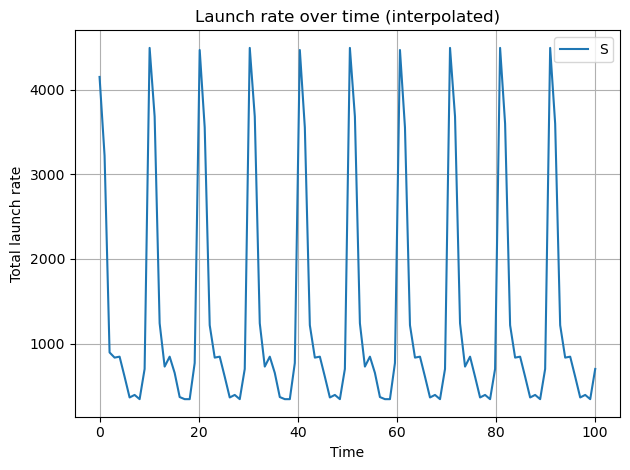

In [ ]:
from scipy.interpolate import interp1d

launch_rate_functions = np.full(
    (scenario_properties.n_sma_bins, n_species, scenario_properties.n_ecc_bins), 
    None, 
    dtype=object
)


if not scenario_properties.baseline:
    for sma in range(scenario_properties.n_sma_bins):
        for species in range(n_species):
            for ecc in range(scenario_properties.n_ecc_bins):
                rate_array = scenario_properties.full_lambda_flattened[sma, species, ecc]

                try:
                    # Default: no launch
                    launch_rate_functions[sma, species, ecc] = None

                    if rate_array is None:
                        continue

                    # Case 1: Clean array directly
                    if isinstance(rate_array, np.ndarray):
                        flattened_array = rate_array.astype(float)

                    # Case 2: Mixed list of array + zeros
                    elif isinstance(rate_array, list):
                        array_found = next((np.asarray(r).astype(float) for r in rate_array if isinstance(r, np.ndarray)), None)
                        if array_found is None:
                            continue
                        flattened_array = array_found

                    # Case 3: Scalar or unexpected input — skip
                    else:
                        continue

                    # Clean
                    flattened_array[np.isnan(flattened_array)] = 0
                    flattened_array[np.isinf(flattened_array)] = 0

                    # Validate
                    if flattened_array.shape[0] != len(scenario_properties.scen_times):
                        continue
                    if np.all(flattened_array == 0):
                        continue

                    # Interpolate
                    interp_func = interp1d(
                        scenario_properties.scen_times,
                        flattened_array,
                        kind='previous',  # or 'linear' if you're okay with smoothing
                        bounds_error=False,
                        fill_value=0
                    )
                    launch_rate_functions[sma, species, ecc] = interp_func

                except Exception as e:
                    raise ValueError(f"Failed processing rate_array at [sma={sma}, species={species}, ecc={ecc}]:\n{rate_array}\n\n{e}")
                
import numpy as np

# Get dimensions
n_sma_bins, n_species, n_ecc_bins = scenario_properties.x0.shape
scen_times = scenario_properties.scen_times
dt = np.diff(scen_times, prepend=scen_times[0])  # Time steps (e.g., in years)
species_names = scenario_properties.species_names

# Initialize total launches tracker per species
total_launches_per_species = np.zeros(n_species)

# Loop through all bins and accumulate launches
for sma in range(n_sma_bins):
    for species in range(n_species):
        for ecc in range(n_ecc_bins):
            func = launch_rate_functions[sma, species, ecc]
            if func is not None:
                try:
                    launch_rates = func(scen_times)  # Evaluate at all times
                    total = np.sum(launch_rates * dt)  # Integrate over time
                    total_launches_per_species[species] += total
                except Exception as e:
                    raise RuntimeError(
                        f"Failed evaluating launch_func at [sma={sma}, species={species}, ecc={ecc}]: {e}"
                    )

# Print totals

total_all = 0
for i, total in enumerate(total_launches_per_species):
    total_all += int(round(total))
    print(f"{species_names[i]}: {int(round(total))} total launches")

print(total_all)

import matplotlib.pyplot as plt

for species in [0]:  # index for S as an example
    flat_launch = np.zeros_like(scenario_properties.scen_times)

    for sma in range(n_sma_bins):
        for ecc in range(n_ecc_bins):
            func = launch_rate_functions[sma, species, ecc]
            if func is not None:
                flat_launch += func(scenario_properties.scen_times)

    plt.plot(scenario_properties.scen_times, flat_launch, label=species_names[species])

plt.xlabel("Time")
plt.ylabel("Total launch rate")
plt.title("Launch rate over time (interpolated)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

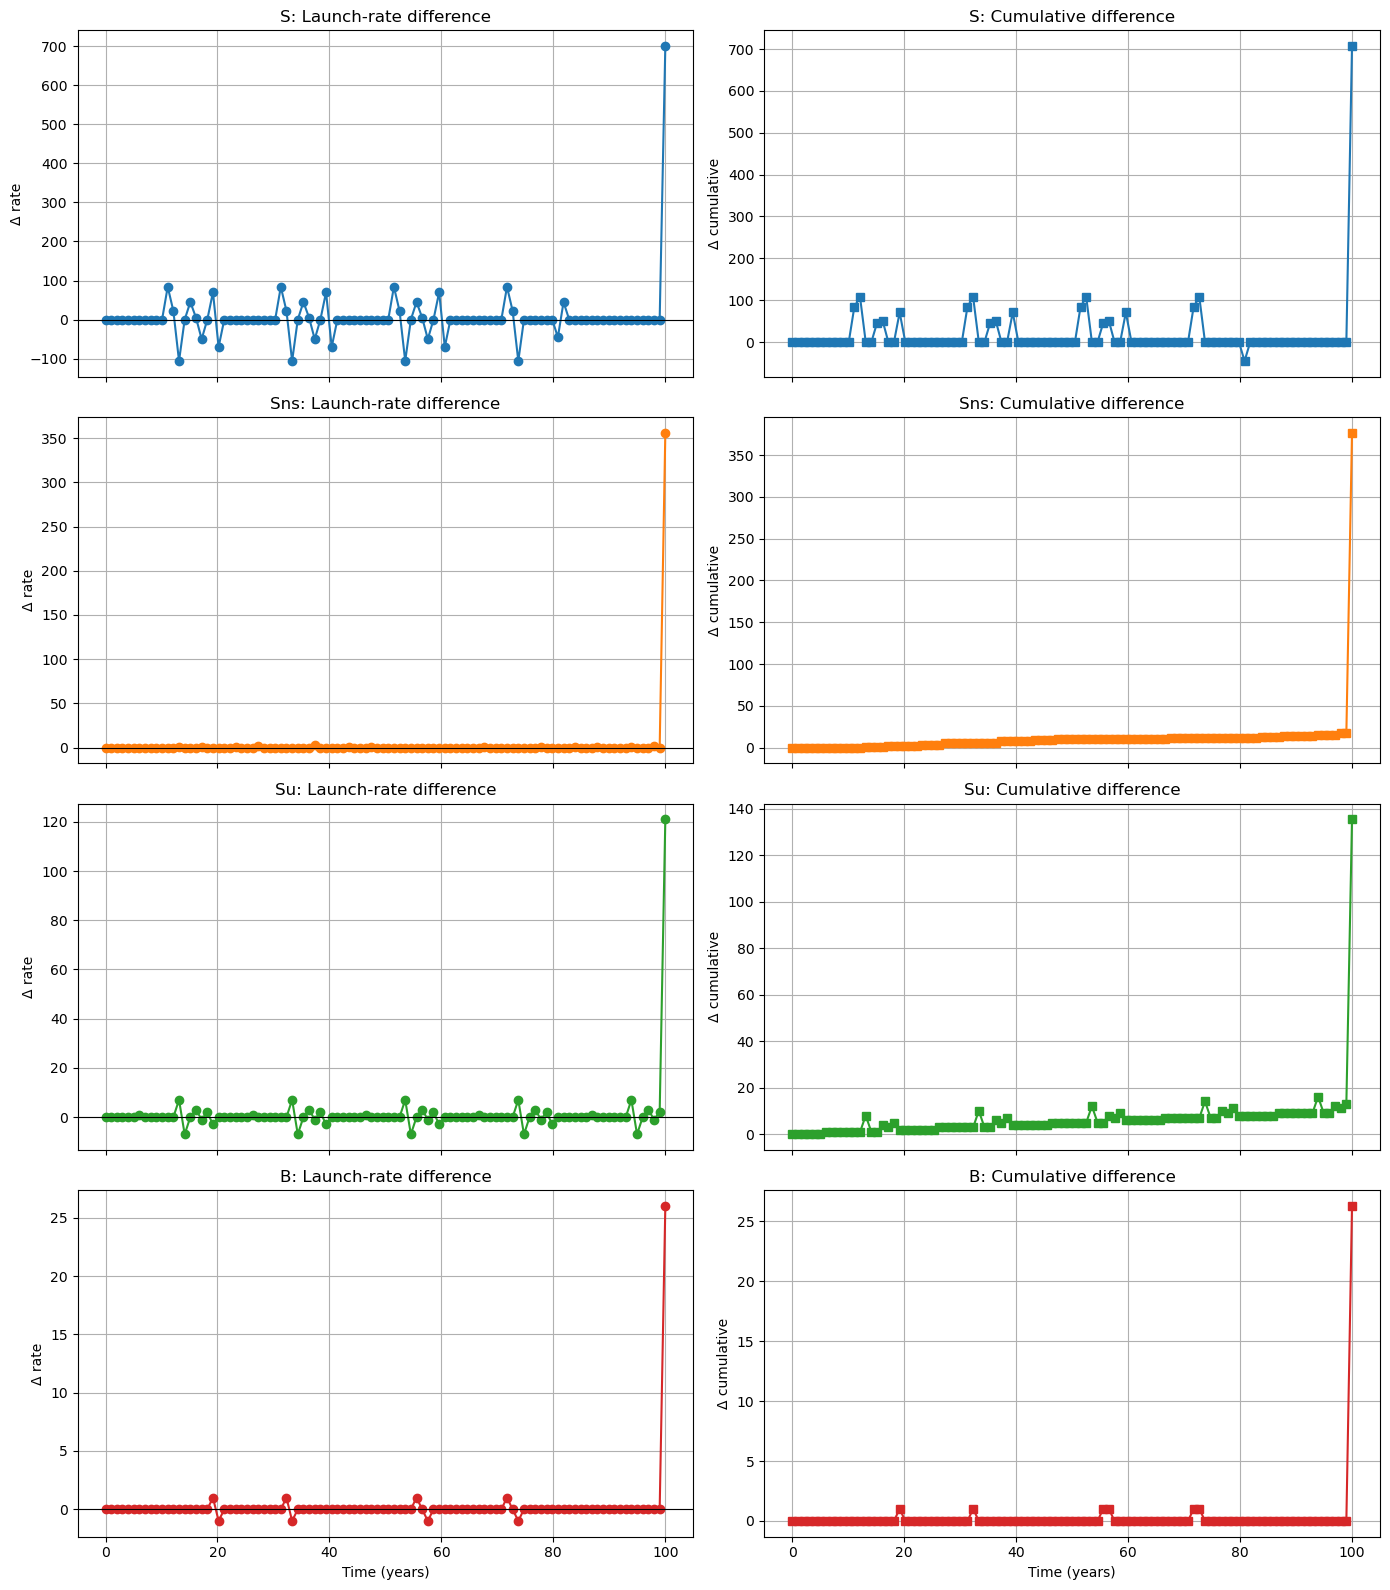

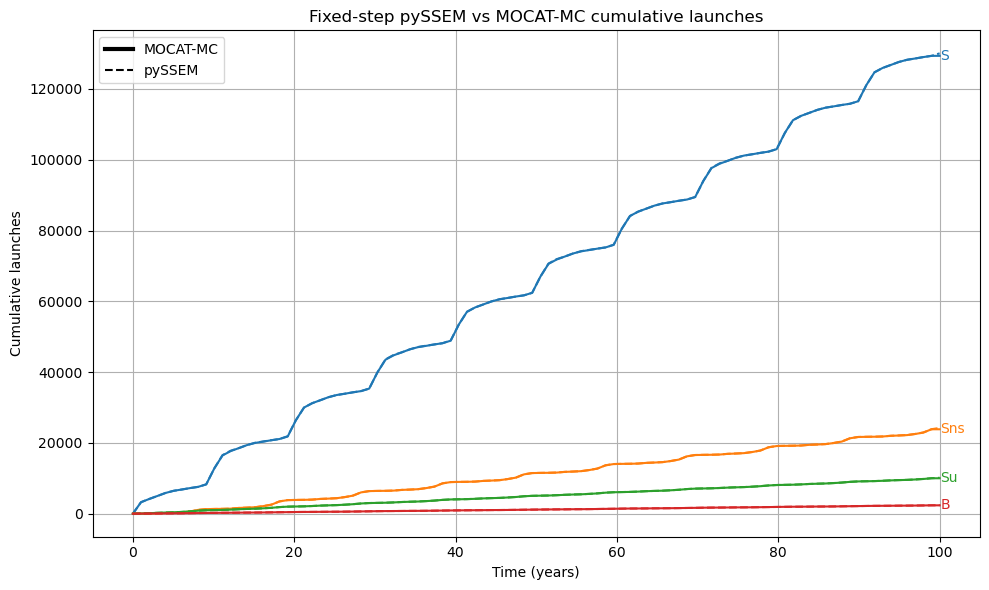

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- Parameters and data ---
scen_times = scenario_properties.scen_times  # numeric years since start
dt = np.diff(scen_times, prepend=scen_times[0])
n_sma, n_species, n_ecc = scenario_properties.x0.shape
species_names = scenario_properties.species_names
target_species = ["S", "Sns", "Su", "B"]

# --- Build MOCAT-MC (SEP2) interpolation functions using numeric years ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_pivot = mc_df.pivot(index='Year', columns='Species', values='Launch_Count')
years_unique = mc_pivot.index.values  # 0,1,2,... up to max year
mc_interp = {
    sp: interp1d(years_unique,
                 mc_pivot[sp].fillna(0).values,
                 kind='previous',
                 bounds_error=False,
                 fill_value=0)
    for sp in target_species
}

# Evaluate MC launch-rate at scen_times (numeric years)
rates_mc = {sp: mc_interp[sp](scen_times) for sp in target_species}

# --- Compute pySSEM fixed-step launch-rate time series ---
rates_pyss = {sp: np.zeros_like(scen_times) for sp in target_species}
for sma in range(n_sma):
    for i_sp, sp in enumerate(species_names):
        if sp in target_species:
            for ecc in range(n_ecc):
                func = launch_rate_functions[sma, i_sp, ecc]
                if func is not None:
                    rates_pyss[sp] += func(scen_times)

# --- Integrate to get cumulative launches ---
cum_pyss = {sp: np.cumsum(rates_pyss[sp] * dt) for sp in target_species}
cum_mc   = {sp: np.cumsum(rates_mc[sp]   * dt) for sp in target_species}

# --- Compute rate and cumulative differences ---
diff_rate = {sp: rates_pyss[sp] - rates_mc[sp] for sp in target_species}
cum_diff  = {sp: cum_pyss[sp] - cum_mc[sp]   for sp in target_species}

# --- 4×2 grid: rate difference (left) and cumulative difference (right) ---
colors = ['C0', 'C1', 'C2', 'C3']
fig, axes = plt.subplots(4, 2, figsize=(14, 16), sharex=True)
for idx, sp in enumerate(target_species):
    c = colors[idx]
    ax_rate = axes[idx, 0]
    ax_cum  = axes[idx, 1]

    ax_rate.plot(scen_times, diff_rate[sp], marker='o', color=c)
    ax_rate.axhline(0, color='black', linewidth=0.8)
    ax_rate.set_title(f"{sp}: Launch‐rate difference")
    ax_rate.set_ylabel("Δ rate")
    ax_rate.grid(True)

    ax_cum.plot(scen_times, cum_diff[sp], marker='s', color=c)
    ax_cum.set_title(f"{sp}: Cumulative difference")
    ax_cum.set_ylabel("Δ cumulative")
    ax_cum.grid(True)

for ax in axes[-1, :]:
    ax.set_xlabel("Time (years)")

plt.tight_layout()
plt.show()

# --- Combined cumulative launches plot with styling ---
plt.figure(figsize=(10, 6))
py_color = 'blue'
mc_color = 'red'
for idx, sp in enumerate(target_species):
    c = colors[idx]
    plt.plot(scen_times, cum_mc[sp], linestyle='-', color=c)
    plt.plot(scen_times, cum_pyss[sp], linestyle='--', color=c)

# Annotate species names at final point
x_off = scen_times[-1] + (scen_times[-1] - scen_times[-2]) * 0.1
for idx, sp in enumerate(target_species):
    y = cum_mc[sp][-1]
    plt.text(x_off, y, sp, va='center', color=colors[idx])

from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], color='black', lw=3, label='MOCAT-MC'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--', label='pySSEM')
]
plt.legend(handles=handles, loc='upper left')

plt.xlabel("Time (years)")
plt.ylabel("Cumulative launches")
plt.title("Fixed‐step pySSEM vs MOCAT-MC cumulative launches")
plt.grid(True)
plt.tight_layout()
plt.show()

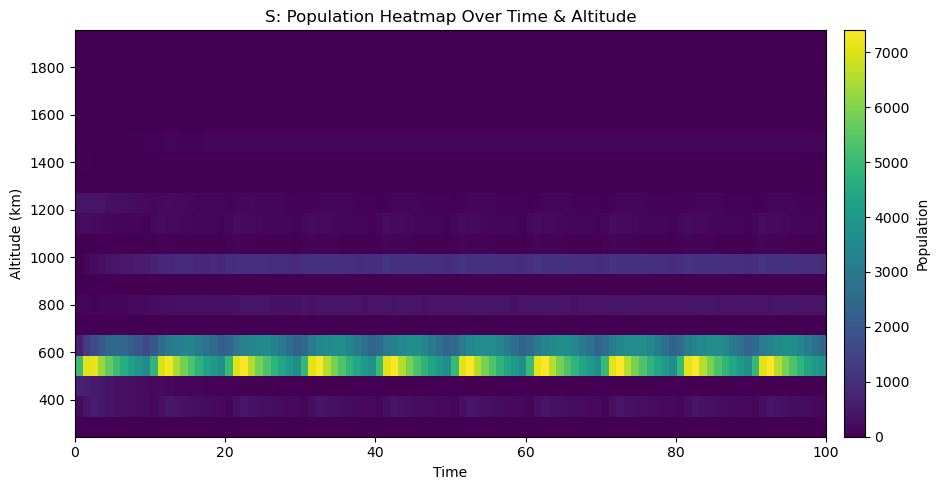

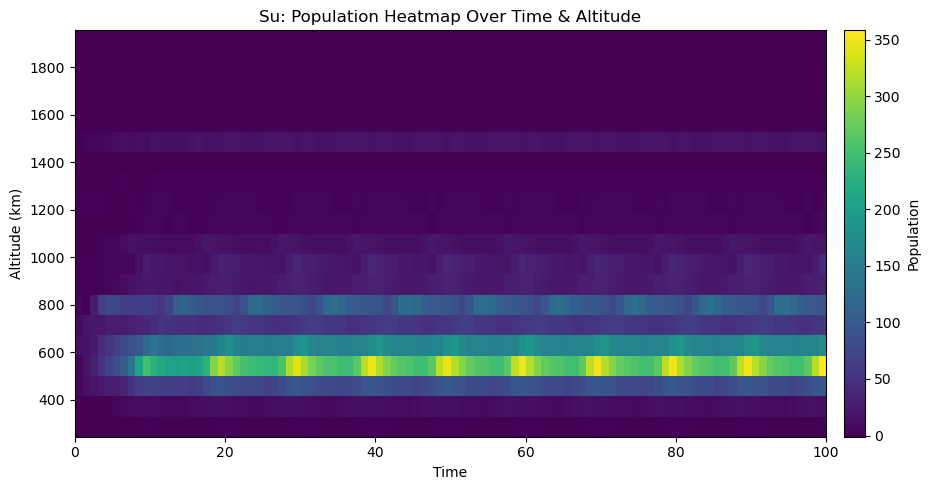

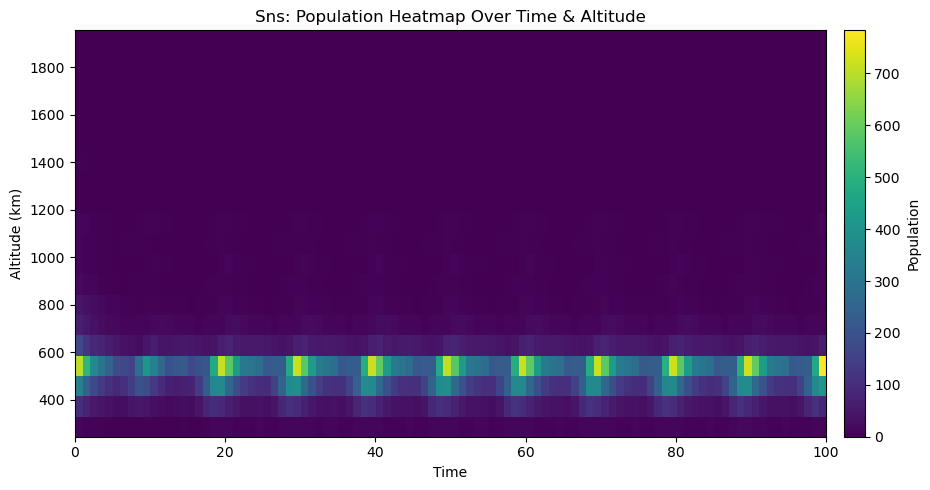

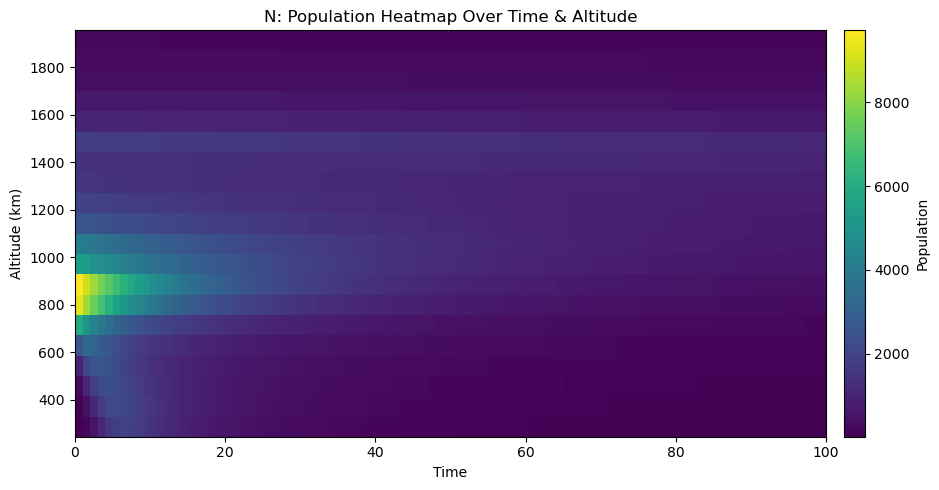

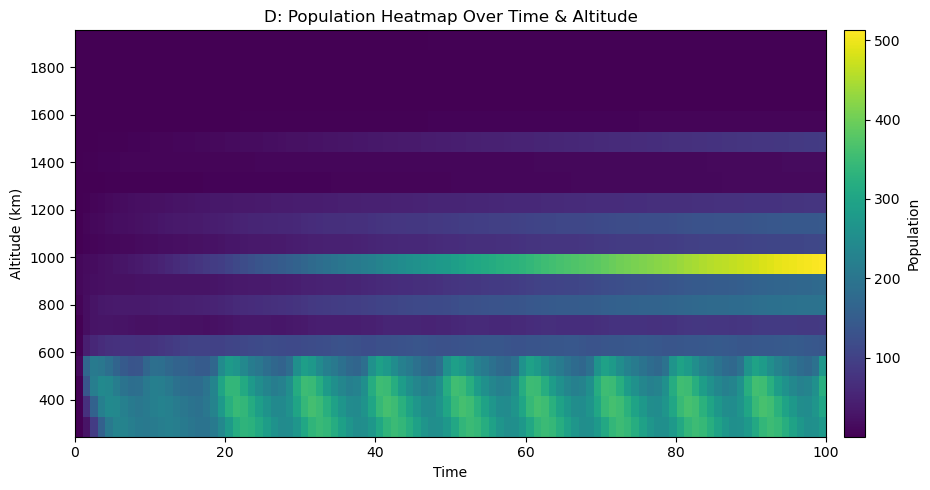

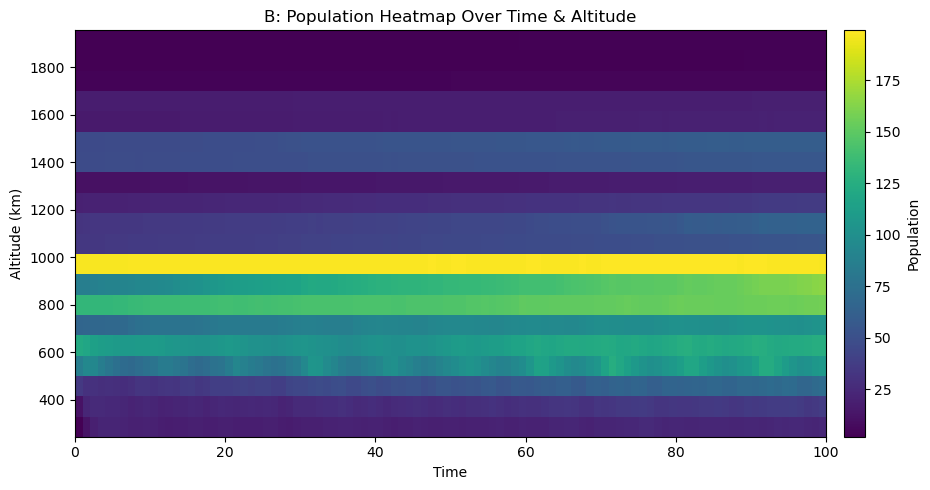

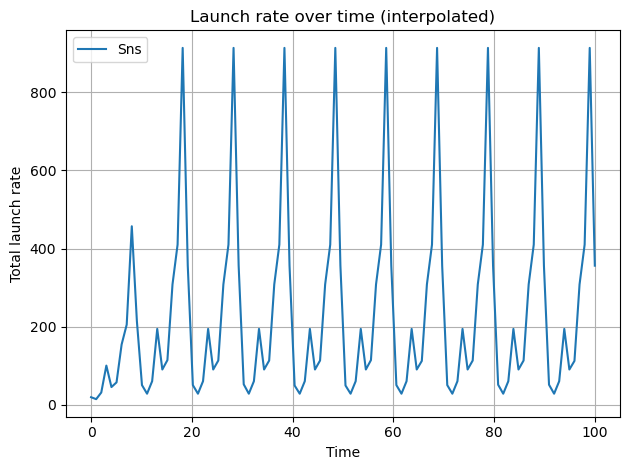

In [ ]:
import matplotlib.pyplot as plt

for species in [1]:  # index for S as an example
    flat_launch = np.zeros_like(scenario_properties.scen_times)

    for sma in range(n_sma_bins):
        for ecc in range(n_ecc_bins):
            func = launch_rate_functions[sma, species, ecc]
            if func is not None:
                flat_launch += func(scenario_properties.scen_times)

    plt.plot(scenario_properties.scen_times, flat_launch, label=species_names[species])

plt.xlabel("Time")
plt.ylabel("Total launch rate")
plt.title("Launch rate over time (interpolated)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

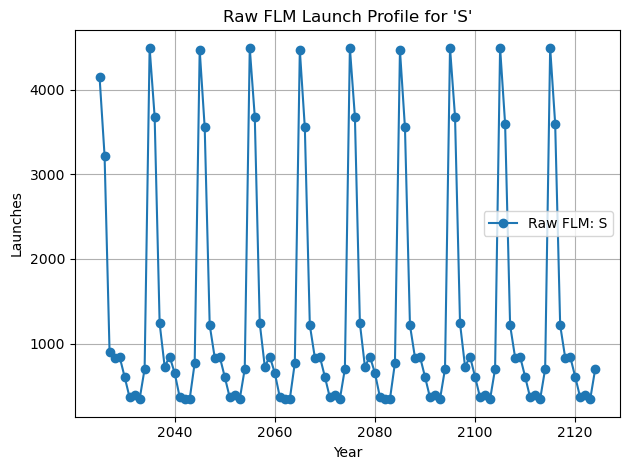

In [ ]:
import pandas as pd

# Convert datetime to float years relative to start of scenario
reference_date = scenario_properties.scen_times[0]  # should already be a float year
S_launch = scenario_properties.FLM_steps.groupby('epoch_start_date')['S'].sum()

# Convert datetime to pandas datetime
datetime_index = pd.to_datetime(S_launch.index)
# Convert to float years (e.g., 2025.0, 2025.5)
float_years = datetime_index.year + (datetime_index.dayofyear - 1) / 365.25

# Now assign index
S_launch.index = float_years

# Plot
import matplotlib.pyplot as plt
plt.plot(S_launch.index, S_launch.values, label='Raw FLM: S', marker='o')
plt.xlabel("Year")
plt.ylabel("Launches")
plt.title("Raw FLM Launch Profile for 'S'")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_86671/2379676068.py:25: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ssem_yearly = ssem_epoch.resample('Y').sum()


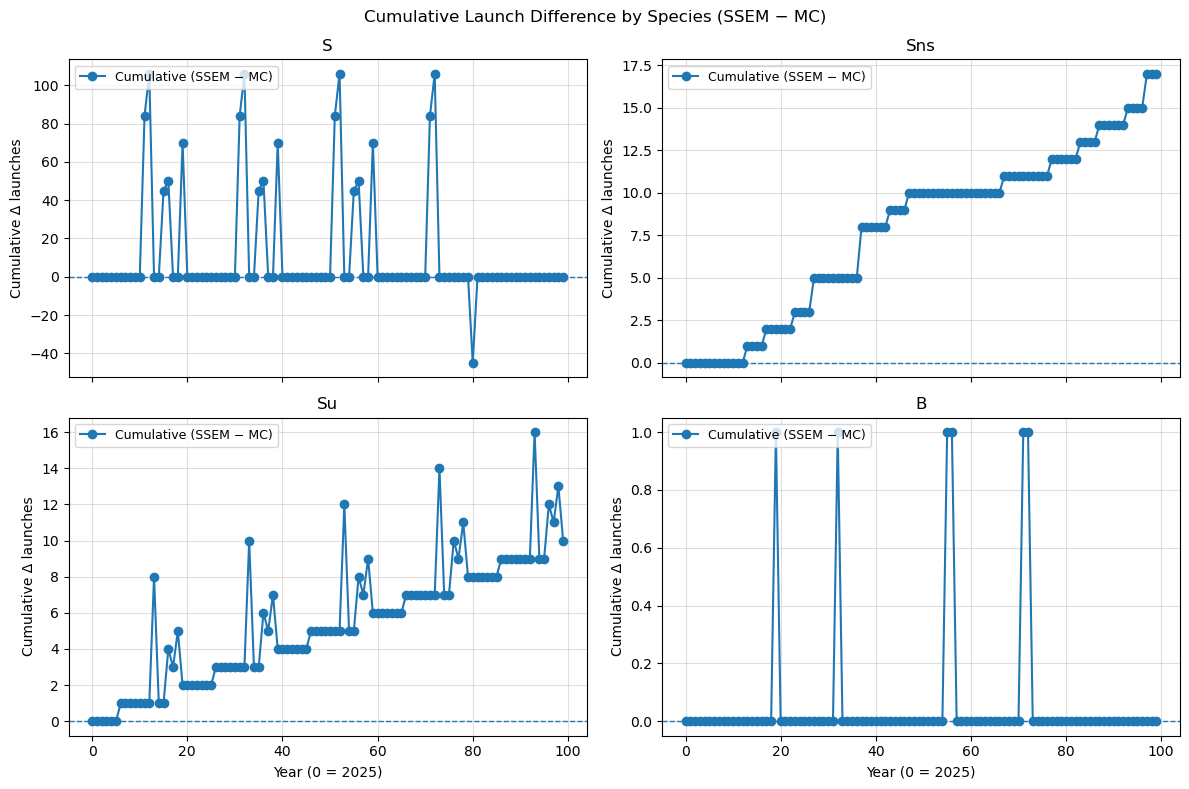

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Inputs ===
mc_csv = '/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts.csv'
target_species = ["S", "Sns", "Su", "B"]

# === 1) MOCAT-MC: Year x Species ===
mc = pd.read_csv(mc_csv)
mc_wide = (
    mc.pivot_table(index='Year', columns='Species', values='Launch_Count', aggfunc='sum')
      .reindex(columns=target_species)
      .fillna(0)
      .sort_index()
)

# === 2) MOCAT-SSEM: sum over bins, then calendar-years -> 0-based year index ===
flm = scenario_properties.FLM_steps.copy()
for sp in target_species:
    if sp not in flm.columns:
        flm[sp] = 0  # ensure all species exist

flm['epoch_start_date'] = pd.to_datetime(flm['epoch_start_date'])
ssem_epoch = flm.groupby('epoch_start_date')[target_species].sum()
ssem_yearly = ssem_epoch.resample('Y').sum()

base_year = int(ssem_yearly.index.min().year)  # typically 2025
ssem_yearly['Year'] = ssem_yearly.index.year - base_year
ssem_wide = ssem_yearly.set_index('Year').sort_index()[target_species]

# If MC "Year=0" corresponds to a different calendar base, shift here:
# mc_wide.index = mc_wide.index + (base_year - 2025)

# === 3) Align on common 0-based years ===
common_years = pd.Index(sorted(mc_wide.index.intersection(ssem_wide.index)))
mc_c   = mc_wide.loc[common_years]
ssem_c = ssem_wide.loc[common_years]

# === 4) Cumulative difference (SSEM − MC) ===
diff = (ssem_c[target_species] - mc_c[target_species]).astype(float)
cumdiff = diff.cumsum()

# === 5) Plot ===
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
for ax, sp in zip(axes.flat, target_species):
    ax.plot(common_years, cumdiff[sp], marker='o', lw=1.5, label='Cumulative (SSEM − MC)')
    ax.axhline(0, ls='--', lw=1)
    ax.set_title(sp)
    ax.set_ylabel('Cumulative Δ launches')
    ax.grid(True, alpha=0.4)
    ax.legend(loc='upper left', fontsize=9)

axes[-1,0].set_xlabel(f'Year (0 = {base_year})')
axes[-1,1].set_xlabel(f'Year (0 = {base_year})')
fig.suptitle('Cumulative Launch Difference by Species (SSEM − MC)', y=0.98)
plt.tight_layout()
plt.show()

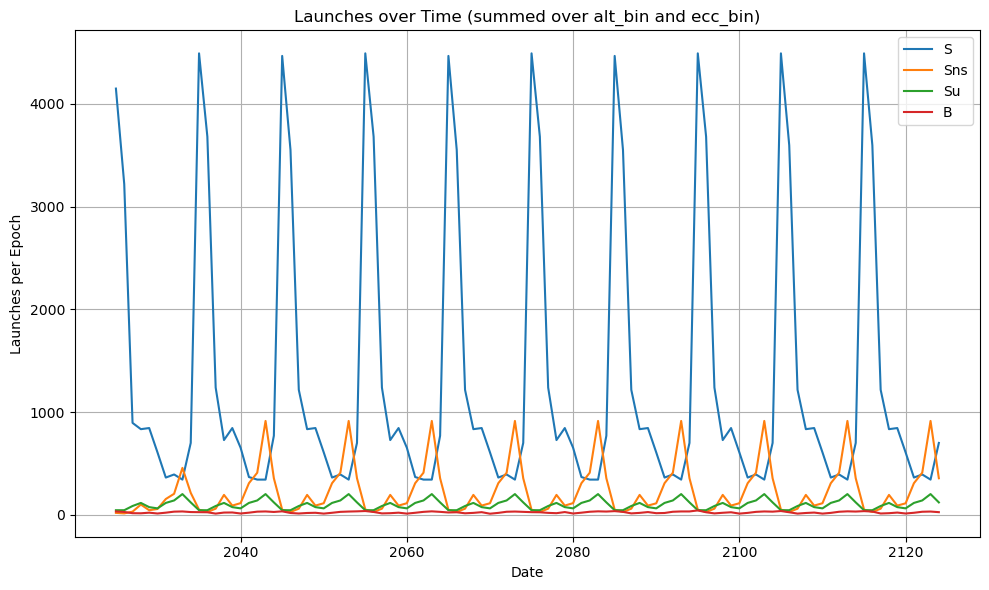

In [ ]:
import matplotlib.pyplot as plt

# List of species to plot
target_species = ["S", "Sns", "Su", "B"]

# Group and sum over all alt_bin and ecc_bin
grouped = scenario_properties.FLM_steps.groupby("epoch_start_date")[target_species].sum()

# Plotting
plt.figure(figsize=(10, 6))
for species in target_species:
    plt.plot(grouped.index, grouped[species], label=species)

plt.xlabel("Date")
plt.ylabel("Launches per Epoch")
plt.title("Launches over Time (summed over alt_bin and ecc_bin)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()